<a href="https://colab.research.google.com/github/Farjana-Yesmin/-Fairness-Aware-Representation-Learning-for-ECG-Based-Disease-Prediction/blob/main/EAI_HealthWear_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install wfdb
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 131.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [ ]:
# Reinstall torch to ensure the CPU-only version (if needed)
!pip uninstall -y torch
!pip install torch==2.6.0 --index-url https://download.pytorch.org/whl/cpu

# Verify torch version
import torch
print(f"Torch version: {torch.__version__}")

Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.6/178.6 MB 5.8 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.8.0+cu126 requires torch==2.8.0, but you have torch 2.6.0+cpu which is incompatible.
torchvision 0.23.0+cu126 requires torch==2.8.0, but you have torch 2.6.0+cpu which is incompatible.
Torch version: 2.6.0+cpu


In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cpu
CUDA available: False


In [ ]:
from google.colab import drive  # Import the necessary module

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1: Download and Extract PTB-XL Dataset
# Download the single .zip file
!wget -O ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip

# Extract the zip file
!unzip -o ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip -d /content/ptb-xl

# Define the data path (adjust for extracted folder structure)
DATA_PATH = '/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

Streaming output truncated to the last 5000 lines.
  inflating: /content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19338_hr.hea  
  inflating: /content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19339_hr.dat  
  inflating: /content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19339_hr.hea  
  inflating: /content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19340_hr.dat  
  inflating: /content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19340_hr.hea  
  inflating: /content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19341_hr.dat  
  inflating: /content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19341_hr.hea  
  inflating: /content/ptb-xl/ptb-xl-a-large-pu

In [ ]:
# Verify the dataset directory
!ls $DATA_PATH

example_physionet.py	  ptbxl_v103_changelog.txt  scp_statements.csv
LICENSE.txt		  RECORDS		    SHA256SUMS.txt
ptbxl_database.csv	  records100
ptbxl_v102_changelog.txt  records500


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import wfdb

# Define the data path (already set in Step 1)
data_path = '/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

class PTBXL_Dataset(Dataset):
    def __init__(self, records, labels, sensitive_attrs):
        self.records = records
        self.labels = labels
        self.sensitive_attrs = sensitive_attrs

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        signal = self.records[idx]
        label = self.labels[idx]
        sensitive = self.sensitive_attrs[idx]
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(sensitive, dtype=torch.long)

def load_ptbxl_data(data_path, subsample_fraction=0.2):
    metadata_path = os.path.join(data_path, 'ptbxl_database.csv')
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata file not found at {metadata_path}")
    metadata = pd.read_csv(metadata_path)

    # Subsample the dataset
    metadata = metadata.sample(frac=subsample_fraction, random_state=42)
    print(f"Subsampled dataset size: {len(metadata)} records")

    # Filter for MI detection (binary classification)
    mi_codes = ['IMI', 'AMI']
    # Parse scp_codes (stored as string representation of dict)
    import ast
    metadata['scp_codes'] = metadata['scp_codes'].apply(ast.literal_eval)
    metadata['label'] = metadata['scp_codes'].apply(lambda x: 1 if any(code in x for code in mi_codes) else 0)
    if metadata['label'].isnull().any():
        raise ValueError("Found NaN values in labels")
    print("Label distribution:", metadata['label'].value_counts())

    # Handle sex: Ensure no NaN values, map to 0/1
    if metadata['sex'].isnull().any():
        print("Found NaN values in 'sex'. Filling with mode.")
        metadata['sex'] = metadata['sex'].fillna(metadata['sex'].mode()[0])
    metadata['sex'] = metadata['sex'].map({0: 0, 1: 1})
    if metadata['sex'].isnull().any():
        raise ValueError("Failed to map 'sex'. Contains invalid values.")
    print("Sex distribution:", metadata['sex'].value_counts())

    # Handle age: Ensure numeric, handle invalid values
    metadata['age'] = pd.to_numeric(metadata['age'], errors='coerce')

    # Inspect age column before cleaning
    print("Age statistics before cleaning:")
    print("NaN count:", metadata['age'].isnull().sum())
    print("Min age:", metadata['age'].min())
    print("Max age:", metadata['age'].max())
    print("Unique ages:", sorted(metadata['age'].unique()))

    # Handle invalid ages
    if metadata['age'].isnull().any():
        print("Found NaN values in 'age'. Filling with median.")
        median_age = metadata['age'].median()
        metadata['age'] = metadata['age'].fillna(median_age)

    # Clip ages to a reasonable range
    metadata['age'] = metadata['age'].clip(lower=0, upper=120)

    # Inspect age column after clipping
    print("Age statistics after clipping:")
    print("Min age:", metadata['age'].min())
    print("Max age:", metadata['age'].max())
    print("Unique ages after clipping:", sorted(metadata['age'].unique()))

    # Bin age into groups
    metadata['age_group'] = pd.cut(metadata['age'],
                                   bins=[0, 40, 60, 121],
                                   labels=[0, 1, 2],
                                   right=False,
                                   include_lowest=True)

    if metadata['age_group'].isnull().any():
        invalid_rows = metadata[metadata['age_group'].isnull()]
        print("Rows with invalid age_group:", invalid_rows[['age', 'age_group']])
        raise ValueError("Failed to bin 'age'. Contains invalid values after cleaning.")
    print("Age group distribution:", metadata['age_group'].value_counts())

    # Load ECG signals
    signals = []
    labels = []
    sensitive_attrs = []

    for idx, row in metadata.iterrows():
        record_path = os.path.join(data_path, row['filename_lr'])
        try:
            signal, _ = wfdb.rdsamp(record_path)
            signal = (signal - signal.mean(axis=0)) / (signal.std(axis=0) + 1e-8)
            signal = signal[:1000, :]  # Truncate to 1000 samples
            signals.append(signal)
            labels.append(row['label'])
            sensitive_attrs.append([row['sex'], row['age_group']])
        except Exception as e:
            print(f"Error loading {record_path}: {e}")
            continue

    signals = np.array(signals)
    labels = np.array(labels)
    sensitive_attrs = np.array(sensitive_attrs)

    # Final validation
    if np.any(np.isnan(labels)):
        raise ValueError("NaN values found in labels after processing")
    if np.any(np.isnan(sensitive_attrs)):
        raise ValueError("NaN values found in sensitive_attrs after processing")

    return signals, labels, sensitive_attrs

# Load and split data (subsample to 20%)
signals, labels, sensitive_attrs = load_ptbxl_data(data_path, subsample_fraction=0.2)
X_train, X_temp, y_train, y_temp, s_train, s_temp = train_test_split(
    signals, labels, sensitive_attrs, test_size=0.3, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test, s_val, s_test = train_test_split(
    X_temp, y_temp, s_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Create datasets and data loaders
train_dataset = PTBXL_Dataset(X_train, y_train, s_train)
val_dataset = PTBXL_Dataset(X_val, y_val, s_val)
test_dataset = PTBXL_Dataset(X_test, y_test, s_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Verify the shapes of the data
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Check a sample batch
for batch in train_loader:
    signals, labels, sensitive = batch
    print(f"Sample batch - Signals shape: {signals.shape}, Labels shape: {labels.shape}, Sensitive attrs shape: {sensitive.shape}")
    break

Subsampled dataset size: 4360 records
Label distribution: label
0    3785
1     575
Name: count, dtype: int64
Sex distribution: sex
0    2263
1    2097
Name: count, dtype: int64
Age statistics before cleaning:
NaN count: 0
Min age: 2.0
Max age: 300.0
Unique ages: [np.float64(2.0), np.float64(5.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0), np.float64(30.0), np.float64(31.0), np.float64(32.0), np.float64(33.0), np.float64(34.0), np.float64(35.0), np.float64(36.0), np.float64(37.0), np.float64(38.0), np.float64(39.0), np.float64(40.0), np.float64(41.0), np.float64(42.0), np.float64(43.0), np.float64(44.0), np.float64(45.0), np.float64(46.0), np.float64(47.0), 

In [ ]:
import torch
import torch.nn as nn


class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class Encoder(nn.Module):
    def __init__(self, input_channels=12, output_dim=128):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class Classifier(nn.Module):
    def __init__(self, input_dim=128, num_classes=2):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

class Adversary(nn.Module):
    def __init__(self, input_dim=128, num_classes=2):
        super(Adversary, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, lambda_):
        x = GradientReversal.apply(x, lambda_)
        return self.model(x)

# Instantiate the models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

encoder = Encoder().to(device)
classifier = Classifier().to(device)
adversary_sex = Adversary(num_classes=2).to(device)  # For sex (0 or 1)
adversary_age = Adversary(num_classes=3).to(device)  # For age_group (0, 1, 2)

# Verify model initialization
print("Encoder:", encoder)
print("Classifier:", classifier)
print("Adversary (Sex):", adversary_sex)
print("Adversary (Age):", adversary_age)

Using device: cpu
Encoder: Encoder(
  (model): Sequential(
    (0): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(128, 256, kernel_size=(5,), stride=(2,), padding=(2,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveAvgPool1d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=256, out_features=128, bias=True)
  )
)
Classifier: Classifier(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)
Adversary (Sex): Adversary(
  (model): Sequential(
    (0): Linear(in_f

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.amp import autocast, GradScaler  # Updated import for PyTorch 2.4.0+

# Use existing device and model instances from Step 3
# device, encoder, classifier, adversary_sex, and adversary_age are already defined

# Set up optimizers
optimizer_enc = optim.Adam(encoder.parameters(), lr=0.001)
optimizer_cls = optim.Adam(classifier.parameters(), lr=0.001)
optimizer_adv_sex = optim.Adam(adversary_sex.parameters(), lr=0.001)
optimizer_adv_age = optim.Adam(adversary_age.parameters(), lr=0.001)

# Add class weights to handle imbalance
class_weights_main = torch.tensor([1.0, 5.0]).to(device)  # Higher weight for MI (class 1) - for main classifier
class_weights_sex = torch.tensor([1.0, 1.0]).to(device)  # Equal weights for sex - for sex adversary
class_weights_age = torch.tensor([1.0, 1.0, 1.0]).to(device)  # Equal weights for age groups - for age adversary

# Use separate criteria for the main classifier, sex adversary, and age adversary
criterion_main = nn.CrossEntropyLoss(weight=class_weights_main)
criterion_sex = nn.CrossEntropyLoss(weight=class_weights_sex)
criterion_age = nn.CrossEntropyLoss(weight=class_weights_age)

# For mixed precision training
scaler = GradScaler('cuda')  # Updated for PyTorch 2.4.0+

# Define the training function
def train_epoch(encoder, classifier, adversary_sex, adversary_age, loader, lambda_, epoch, num_epochs):
    encoder.train()
    classifier.train()
    adversary_sex.train()
    adversary_age.train()

    total_loss = 0
    task_loss_total = 0
    adv_loss_sex_total = 0
    adv_loss_age_total = 0

    for signals, labels, sensitive in loader:
        signals = signals.permute(0, 2, 1).to(device)  # [batch, 1000, 12] -> [batch, 12, 1000]
        labels = labels.to(device)
        sex = sensitive[:, 0].to(device)
        age = sensitive[:, 1].to(device)

        # Forward pass for task
        with autocast('cuda'):  # Updated for PyTorch 2.4.0+
            z = encoder(signals)
            task_pred = classifier(z)
            adv_pred_sex = adversary_sex(z, lambda_)
            adv_pred_age = adversary_age(z, lambda_)

            task_loss = criterion_main(task_pred, labels)  # Use criterion_main for MI classification
            adv_loss_sex = criterion_sex(adv_pred_sex, sex)  # Use criterion_sex for sex adversary
            adv_loss_age = criterion_age(adv_pred_age, age)  # Use criterion_age for age adversary
            total_adv_loss = adv_loss_sex + adv_loss_age
            loss = task_loss - lambda_ * total_adv_loss

        # Backward pass for encoder and classifier
        optimizer_enc.zero_grad()
        optimizer_cls.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer_enc)
        scaler.step(optimizer_cls)
        scaler.update()

        # Backward pass for adversary_sex
        with autocast('cuda'):  # Updated for PyTorch 2.4.0+
            z_sex = encoder(signals.detach())
            adv_pred_sex = adversary_sex(z_sex, lambda_)
            adv_loss_sex = criterion_sex(adv_pred_sex, sex)  # Use criterion_sex

        optimizer_adv_sex.zero_grad()
        scaler.scale(adv_loss_sex).backward()
        scaler.step(optimizer_adv_sex)
        scaler.update()

        # Backward pass for adversary_age
        with autocast('cuda'):  # Updated for PyTorch 2.4.0+
            z_age = encoder(signals.detach())
            adv_pred_age = adversary_age(z_age, lambda_)
            adv_loss_age = criterion_age(adv_pred_age, age)  # Use criterion_age

        optimizer_adv_age.zero_grad()
        scaler.scale(adv_loss_age).backward()
        scaler.step(optimizer_adv_age)
        scaler.update()

        # Accumulate losses for logging
        total_loss += loss.item()
        task_loss_total += task_loss.item()
        adv_loss_sex_total += adv_loss_sex.item()
        adv_loss_age_total += adv_loss_age.item()

    avg_total_loss = total_loss / len(loader)
    avg_task_loss = task_loss_total / len(loader)
    avg_adv_loss_sex = adv_loss_sex_total / len(loader)
    avg_adv_loss_age = adv_loss_age_total / len(loader)

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {avg_total_loss:.4f}, '
          f'Task: {avg_task_loss:.4f}, '
          f'Adv_Sex: {avg_adv_loss_sex:.4f}, '
          f'Adv_Age: {avg_adv_loss_age:.4f}')

    return avg_total_loss, avg_task_loss, avg_adv_loss_sex, avg_adv_loss_age

# Test one epoch to verify the training loop
lambda_ = 0.1  # Example lambda value
num_epochs = 1  # Run for 1 epoch to test
train_epoch(encoder, classifier, adversary_sex, adversary_age, train_loader, lambda_, 0, num_epochs)

/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [1/1] Loss: 0.4068, Task: 0.5720, Adv_Sex: 0.6896, Adv_Age: 0.9631


(0.4068269217386842,
 0.5719859904299179,
 0.6896244361996651,
 0.9631128174563249)

In [ ]:
num_epochs = 10
lambda_max = 0.1
for epoch in range(num_epochs):
    lambda_ = lambda_max * min(1.0, (epoch + 1) / 10.0)
    train_epoch(encoder, classifier, adversary_sex, adversary_age, train_loader, lambda_, epoch, num_epochs)

Epoch [1/10] Loss: 0.4521, Task: 0.4681, Adv_Sex: 0.6834, Adv_Age: 0.9133
Epoch [2/10] Loss: 0.3935, Task: 0.4253, Adv_Sex: 0.6882, Adv_Age: 0.9064
Epoch [3/10] Loss: 0.3571, Task: 0.4050, Adv_Sex: 0.6879, Adv_Age: 0.9122
Epoch [4/10] Loss: 0.3238, Task: 0.3873, Adv_Sex: 0.6874, Adv_Age: 0.9008
Epoch [5/10] Loss: 0.2810, Task: 0.3612, Adv_Sex: 0.6867, Adv_Age: 0.9200
Epoch [6/10] Loss: 0.2695, Task: 0.3650, Adv_Sex: 0.6865, Adv_Age: 0.9033
Epoch [7/10] Loss: 0.2522, Task: 0.3648, Adv_Sex: 0.6873, Adv_Age: 0.9223
Epoch [8/10] Loss: 0.1977, Task: 0.3248, Adv_Sex: 0.6868, Adv_Age: 0.9004
Epoch [9/10] Loss: 0.1549, Task: 0.2968, Adv_Sex: 0.6866, Adv_Age: 0.8893
Epoch [10/10] Loss: 0.1144, Task: 0.2706, Adv_Sex: 0.6894, Adv_Age: 0.8709


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

def evaluate(encoder, classifier, loader):
    encoder.eval()
    classifier.eval()

    preds = []
    labels = []
    sex_attrs = []
    age_attrs = []

    with torch.no_grad():
        for signals, lbls, sensitive in loader:
            signals = signals.permute(0, 2, 1).to(device)
            z = encoder(signals)
            pred = classifier(z)
            preds.append(torch.softmax(pred, dim=1).cpu().numpy())
            labels.append(lbls.numpy())
            sex_attrs.append(sensitive[:, 0].numpy())
            age_attrs.append(sensitive[:, 1].numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    sex_attrs = np.concatenate(sex_attrs)
    age_attrs = np.concatenate(age_attrs)

    y_pred = np.argmax(preds, axis=1)
    y_score = preds[:, 1]
    acc = accuracy_score(labels, y_pred)
    f1 = f1_score(labels, y_pred)
    auroc = roc_auc_score(labels, y_score)

    def demographic_parity_diff(y_pred, s, num_classes):
        probs = []
        for i in range(num_classes):
            prob = np.mean(y_pred[s == i]) if np.sum(s == i) > 0 else 0
            probs.append(prob)
        return np.max(probs) - np.min(probs) if probs else 0

    def equalized_odds_diff(y_pred, y_true, s, num_classes):
        tprs, fprs = [], []
        for i in range(num_classes):
            mask_true = (y_true == 1) & (s == i)
            mask_false = (y_true == 0) & (s == i)
            tpr = np.mean(y_pred[mask_true]) if np.sum(mask_true) > 0 else 0
            fpr = np.mean(y_pred[mask_false]) if np.sum(mask_false) > 0 else 0
            tprs.append(tpr)
            fprs.append(fpr)
        tpr_diff = np.max(tprs) - np.min(tprs) if tprs else 0
        fpr_diff = np.max(fprs) - np.min(fprs) if fprs else 0
        return max(tpr_diff, fpr_diff)

    def disparate_impact(y_pred, s, num_classes):
        probs = []
        for i in range(num_classes):
            prob = np.mean(y_pred[s == i]) if np.sum(s == i) > 0 else 0
            probs.append(prob)
        probs = [p for p in probs if p > 0]  # Avoid division by zero
        return min(probs) / max(probs) if probs else 0

    # Compute fairness metrics for sex (2 classes: 0, 1)
    dpd_sex = demographic_parity_diff(y_pred, sex_attrs, num_classes=2)
    eod_sex = equalized_odds_diff(y_pred, labels, sex_attrs, num_classes=2)
    di_sex = disparate_impact(y_pred, sex_attrs, num_classes=2)

    # Compute fairness metrics for age (3 classes: 0, 1, 2)
    dpd_age = demographic_parity_diff(y_pred, age_attrs, num_classes=3)
    eod_age = equalized_odds_diff(y_pred, labels, age_attrs, num_classes=3)
    di_age = disparate_impact(y_pred, age_attrs, num_classes=3)

    return {
        'AUROC': auroc,
        'Accuracy': acc,
        'F1': f1,
        'DPD_Sex': dpd_sex,
        'EOD_Sex': eod_sex,
        'DI_Sex': di_sex,
        'DPD_Age': dpd_age,
        'EOD_Age': eod_age,
        'DI_Age': di_age
    }

# Evaluate on test set
metrics = evaluate(encoder, classifier, test_loader)
print("Test Metrics:", metrics)

Test Metrics: {'AUROC': np.float64(0.8530543727481165), 'Accuracy': 0.8685015290519877, 'F1': 0.5567010309278351, 'DPD_Sex': np.float64(0.04187874251497006), 'EOD_Sex': np.float64(0.20077220077220082), 'DI_Sex': np.float64(0.7743951612903226), 'DPD_Age': np.float64(0.2069754698127196), 'EOD_Age': np.float64(0.6666666666666666), 'DI_Age': np.float64(0.05629041740152851)}


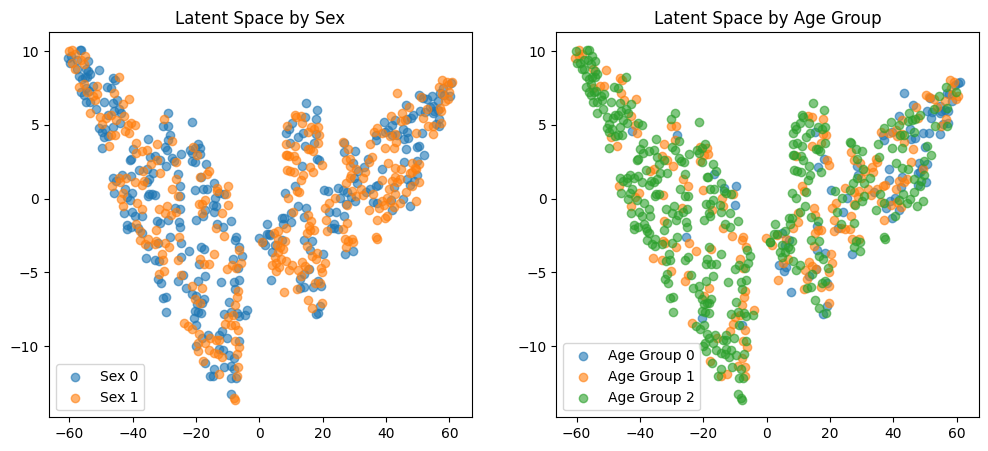

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_latent_space(encoder, loader):
    encoder.eval()
    z_list = []
    labels = []
    sex_attrs = []
    age_attrs = []

    with torch.no_grad():
        for signals, lbls, sensitive in loader:
            signals = signals.permute(0, 2, 1).to(device)
            z = encoder(signals)
            z_list.append(z.cpu().numpy())
            labels.append(lbls.numpy())
            sex_attrs.append(sensitive[:, 0].numpy())
            age_attrs.append(sensitive[:, 1].numpy())

    z = np.concatenate(z_list)
    labels = np.concatenate(labels)
    sex_attrs = np.concatenate(sex_attrs)
    age_attrs = np.concatenate(age_attrs)

    z_2d = TSNE(n_components=2, random_state=42).fit_transform(z)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for s in np.unique(sex_attrs):
        mask = sex_attrs == s
        plt.scatter(z_2d[mask, 0], z_2d[mask, 1], label=f'Sex {s}', alpha=0.6)
    plt.title("Latent Space by Sex")
    plt.legend()

    plt.subplot(1, 2, 2)
    for a in np.unique(age_attrs):
        mask = age_attrs == a
        plt.scatter(z_2d[mask, 0], z_2d[mask, 1], label=f'Age Group {a}', alpha=0.6)
    plt.title("Latent Space by Age Group")
    plt.legend()

    plt.show()

visualize_latent_space(encoder, test_loader)

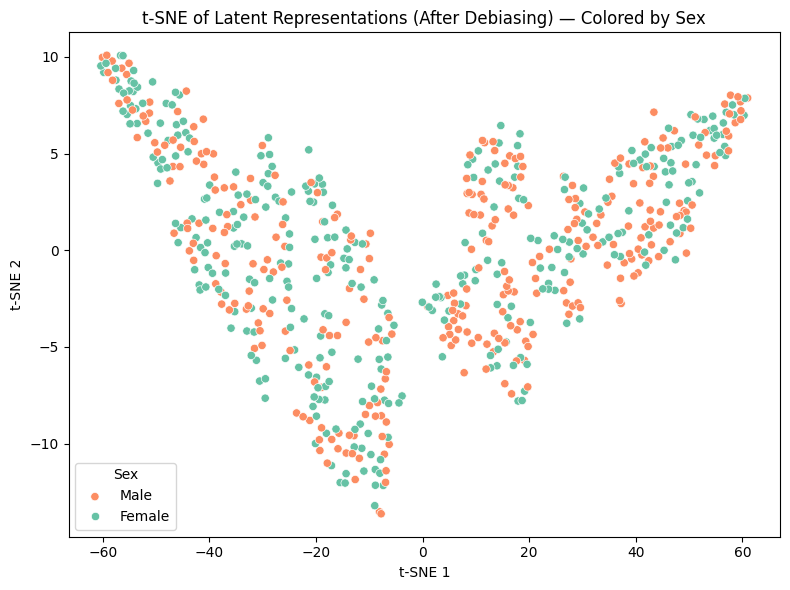

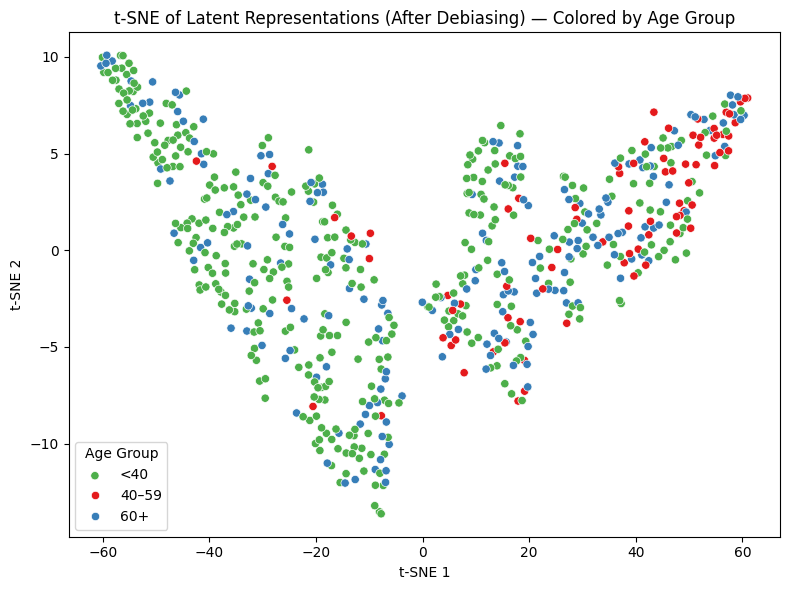

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def extract_latents(encoder, loader):
    encoder.eval()
    latents = []
    sex_attrs = []
    age_attrs = []
    with torch.no_grad():
        for signals, _, sensitive in loader:
            signals = signals.permute(0, 2, 1).to(device)
            z = encoder(signals)
            latents.append(z.cpu().numpy())
            sex_attrs.append(sensitive[:, 0].numpy())
            age_attrs.append(sensitive[:, 1].numpy())
    return (
        np.concatenate(latents),
        np.concatenate(sex_attrs),
        np.concatenate(age_attrs)
    )

# Get latent features and attributes from the test set
latents, sex, age_group = extract_latents(encoder, test_loader)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_proj = tsne.fit_transform(latents)

# Plot by sex
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=sex, palette="Set2")
plt.title("t-SNE of Latent Representations (After Debiasing) — Colored by Sex")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Sex", labels=["Male", "Female"])
plt.tight_layout()
plt.savefig("tsne_debiased_sex.png")
plt.show()

# Plot by age group
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=age_group, palette="Set1")
plt.title("t-SNE of Latent Representations (After Debiasing) — Colored by Age Group")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Age Group", labels=["<40", "40–59", "60+"])
plt.tight_layout()
plt.savefig("tsne_debiased_age.png")
plt.show()


In [ ]:
import pandas as pd
import wfdb
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import ast

# Define data path
DATA_PATH = '/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

class ECGDataset(Dataset):
    def __init__(self, signals, labels, sexes, ages):
        self.signals = torch.tensor(signals, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)  # Labels should be long for CrossEntropyLoss
        self.sexes = torch.tensor(sexes, dtype=torch.long)
        self.ages = torch.tensor(ages, dtype=torch.long)
    def __len__(self): return len(self.signals)
    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx], self.sexes[idx], self.ages[idx]

def load_ptbxl_data_robust(data_path, subsample_fraction=0.2):
    metadata_path = os.path.join(data_path, 'ptbxl_database.csv')
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata file not found at {metadata_path}")
    metadata = pd.read_csv(metadata_path)

    # Subsample the dataset
    metadata = metadata.sample(frac=subsample_fraction, random_state=42)
    print(f"Subsampled dataset size: {len(metadata)} records")

    # Filter for MI detection (binary classification)
    mi_codes = ['IMI', 'AMI']
    # Parse scp_codes (stored as string representation of dict)
    metadata['scp_codes'] = metadata['scp_codes'].apply(ast.literal_eval)
    metadata['label'] = metadata['scp_codes'].apply(lambda x: 1 if any(code in x for code in mi_codes) else 0)
    if metadata['label'].isnull().any():
        raise ValueError("Found NaN values in labels")
    print("Label distribution:", metadata['label'].value_counts())

    # Handle sex: Ensure no NaN values, map to 0/1
    if metadata['sex'].isnull().any():
        print("Found NaN values in 'sex'. Filling with mode.")
        metadata['sex'] = metadata['sex'].fillna(metadata['sex'].mode()[0])
    metadata['sex'] = metadata['sex'].map({0: 0, 1: 1})
    if metadata['sex'].isnull().any():
        raise ValueError("Failed to map 'sex'. Contains invalid values.")
    print("Sex distribution:", metadata['sex'].value_counts())

    # Handle age: Ensure numeric, handle invalid values
    metadata['age'] = pd.to_numeric(metadata['age'], errors='coerce')

    # Handle invalid ages
    if metadata['age'].isnull().any():
        print("Found NaN values in 'age'. Filling with median.")
        median_age = metadata['age'].median()
        metadata['age'] = metadata['age'].fillna(median_age)

    # Clip ages to a reasonable range
    metadata['age'] = metadata['age'].clip(lower=0, upper=120)

    # Bin age into groups
    metadata['age_group'] = pd.cut(metadata['age'],
                                   bins=[0, 40, 60, 121],
                                   labels=[0, 1, 2],
                                   right=False,
                                   include_lowest=True)

    if metadata['age_group'].isnull().any():
        invalid_rows = metadata[metadata['age_group'].isnull()]
        print("Rows with invalid age_group:", invalid_rows[['age', 'age_group']])
        raise ValueError("Failed to bin 'age'. Contains invalid values after cleaning.")
    print("Age group distribution:", metadata['age_group'].value_counts())

    # Load ECG signals
    signals = []
    labels = []
    sexes = []
    ages = []

    for idx, row in metadata.iterrows():
        record_path = os.path.join(data_path, row['filename_lr'])
        try:
            signal, _ = wfdb.rdsamp(record_path)
            signal = (signal - signal.mean(axis=0)) / (signal.std(axis=0) + 1e-8)
            signal = signal[:1000, :]  # Truncate to 1000 samples
            signals.append(signal)
            labels.append(row['label'])
            sexes.append(row['sex'])
            ages.append(row['age_group'])
        except Exception as e:
            print(f"Error loading {record_path}: {e}")
            continue

    signals = np.array(signals)
    labels = np.array(labels)
    sexes = np.array(sexes)
    ages = np.array(ages)

    # Final validation
    if np.any(np.isnan(labels)):
        raise ValueError("NaN values found in labels after processing")
    if np.any(np.isnan(sexes)):
        raise ValueError("NaN values found in sexes after processing")
    if np.any(np.isnan(ages)):
         raise ValueError("NaN values found in ages after processing")

    return signals, labels, sexes, ages

# Load and split data (subsample to 20%)
signals, labels, sexes, ages = load_ptbxl_data_robust(DATA_PATH, subsample_fraction=0.2)

# Split dataset
X_train, X_temp, y_train, y_temp, sex_train, sex_temp, age_train, age_temp = train_test_split(
    signals, labels, sexes, ages, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test, sex_val, sex_test, age_val, age_test = train_test_split(
    X_temp, y_temp, sex_temp, age_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Custom Dataset
train_dataset = ECGDataset(X_train, y_train, sex_train, age_train)
val_dataset = ECGDataset(X_val, y_val, sex_val, age_val)
test_dataset = ECGDataset(X_test, y_test, sex_test, age_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

Subsampled dataset size: 4360 records
Label distribution: label
0    3785
1     575
Name: count, dtype: int64
Sex distribution: sex
0    2263
1    2097
Name: count, dtype: int64
Age group distribution: age_group
2    2404
1    1371
0     585
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim

# Define model (as in original)
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class Encoder(nn.Module):
    def __init__(self, input_channels=12, output_dim=128):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class Classifier(nn.Module):
    def __init__(self, input_dim=128, num_classes=2):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

class Adversary(nn.Module):
    def __init__(self, input_dim=128, num_classes=2):
        super(Adversary, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, lambda_):
        x = GradientReversalLayer.apply(x, lambda_)
        return self.model(x)

# Training function
def train_model(encoder, classifier, adv_sex, adv_age, train_loader, device, lambda_val=0.3, epochs=20):
    optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()) +
                          list(adv_sex.parameters()) + list(adv_age.parameters()), lr=0.001)
    criterion_class = nn.CrossEntropyLoss() # Changed to CrossEntropyLoss
    criterion_adv_sex = nn.CrossEntropyLoss() # Assuming 2 classes for sex adversary
    criterion_adv_age = nn.CrossEntropyLoss() # Assuming 3 classes for age adversary


    for epoch in range(epochs):
        encoder.train()
        classifier.train()
        adv_sex.train()
        adv_age.train()
        for signals, labels, sexes, ages in train_loader:
            signals = signals.permute(0, 2, 1).to(device)
            labels, sexes, ages = labels.to(device), sexes.to(device), ages.to(device)
            optimizer.zero_grad()

            # Train classifier and encoder to minimize main task loss and maximize adversary loss
            z = encoder(signals)
            pred = classifier(z) # Removed .squeeze()
            # Ensure labels are float for BCELoss
            loss_class = criterion_class(pred, labels)

            pred_sex = adv_sex(GradientReversalLayer.apply(z, lambda_val), lambda_val)
            pred_age = adv_age(GradientReversalLayer.apply(z, lambda_val), lambda_val)
            loss_adv = criterion_adv_sex(pred_sex, sexes) + criterion_adv_age(pred_age, ages)
            loss = loss_class - lambda_val * loss_adv

            loss.backward()
            optimizer.step()

            # Train adversaries to minimize adversary loss
            optimizer.zero_grad()
            z = encoder(signals.detach())  # Detach to prevent gradients flowing to encoder
            pred_sex = adv_sex(z, lambda_val) # Added lambda_val
            pred_age = adv_age(z, lambda_val) # Added lambda_val
            loss_adv = criterion_adv_sex(pred_sex, sexes) + criterion_adv_age(pred_age, ages)

            loss_adv.backward()
            optimizer.step()


    return encoder, classifier

# Evaluation function
def evaluate_model(encoder, classifier, test_loader, device):
    encoder.eval()
    classifier.eval()
    preds, truths = [], []
    sex_attrs, age_attrs = [], [] # Collect sensitive attributes as well

    with torch.no_grad():
        for signals, labels, sexes, ages in test_loader:
            signals = signals.permute(0, 2, 1).to(device)
            z = encoder(signals)
            pred = classifier(z)
            preds.extend(torch.softmax(pred, dim=1)[:, 1].cpu().numpy()) # Use softmax for probabilities and take class 1
            truths.extend(labels.cpu().numpy())
            sex_attrs.extend(sexes.cpu().numpy())
            age_attrs.extend(ages.cpu().numpy())


    auroc = roc_auc_score(truths, preds)
    preds_bin = (np.array(preds) > 0.5).astype(int)
    acc = accuracy_score(truths, preds_bin)
    f1 = f1_score(truths, preds_bin)

    # Fairness metrics (simplified DPD for sex)
    def demographic_parity_diff(y_pred, s, num_classes):
        probs = []
        for i in range(num_classes):
            prob = np.mean(y_pred[s == i]) if np.sum(s == i) > 0 else 0
            probs.append(prob)
        return np.max(probs) - np.min(probs) if probs else 0

    dpd_sex = demographic_parity_diff(preds_bin, np.array(sex_attrs), num_classes=2)
    dpd_age = demographic_parity_diff(preds_bin, np.array(age_attrs), num_classes=3)

    return auroc, acc, f1, dpd_sex, dpd_age

# 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
aurocs, accs, f1s, dpds_sex, dpds_age = [], [], [], [], []

# Ensure signals, labels, sexes, ages are defined from the previous cell execution
# signals, labels, sexes, ages = load_ptbxl_data_robust(DATA_PATH, subsample_fraction=0.2) # This line is already executed in the previous cell

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Define device here

for fold, (train_idx, test_idx) in enumerate(kf.split(signals)):
    train_dataset = ECGDataset(signals[train_idx], labels[train_idx], sexes[train_idx], ages[train_idx])
    test_dataset = ECGDataset(signals[test_idx], labels[test_idx], sexes[test_idx], ages[test_idx])
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128)

    encoder = Encoder().to(device)
    classifier = Classifier().to(device)
    adv_sex = Adversary(num_classes=2).to(device)  # Specify num_classes for sex adversary
    adv_age = Adversary(num_classes=3).to(device)  # Specify num_classes for age adversary

    encoder, classifier = train_model(encoder, classifier, adv_sex, adv_age, train_loader, device)
    auroc, acc, f1, dpd_sex, dpd_age = evaluate_model(encoder, classifier, test_loader, device)
    aurocs.append(auroc)
    accs.append(acc)
    f1s.append(f1)
    dpds_sex.append(dpd_sex)
    dpds_age.append(dpd_age)

    print(f"Fold {fold+1}: AUROC={auroc:.4f}, Acc={acc:.4f}, F1={f1:.4f}, DPD_Sex={dpd_sex:.4f}, DPD_Age={dpd_age:.4f}")

print(f"Mean AUROC: {np.mean(aurocs):.4f} ± {np.std(aurocs):.4f}")
print(f"Mean DPD_Sex: {np.mean(dpds_sex):.4f} ± {np.std(dpds_sex):.4f}")
print(f"Mean DPD_Age: {np.mean(dpds_age):.4f} ± {np.std(dpds_age):.4f}")

Fold 1: AUROC=0.8397, Acc=0.8567, F1=0.4939, DPD_Sex=0.0206, DPD_Age=0.1612
Fold 2: AUROC=0.8239, Acc=0.8417, F1=0.4567, DPD_Sex=0.0651, DPD_Age=0.1333
Fold 3: AUROC=0.8591, Acc=0.9025, F1=0.4295, DPD_Sex=0.0288, DPD_Age=0.0382
Fold 4: AUROC=0.8468, Acc=0.8612, F1=0.5217, DPD_Sex=0.0418, DPD_Age=0.1469
Fold 5: AUROC=0.8662, Acc=0.7477, F1=0.4954, DPD_Sex=0.0921, DPD_Age=0.2929
Mean AUROC: 0.8472 ± 0.0149
Mean DPD_Sex: 0.0497 ± 0.0260
Mean DPD_Age: 0.1545 ± 0.0815


In [ ]:
# Demographics-as-Features Baseline
class EncoderWithDemog(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder().to(device)
        self.fc = nn.Linear(128 + 2 + 3, 128)  # Concatenate encoder output (128), sex (2) + age (3) one-hot
    def forward(self, x, sex, age):
        z = self.encoder(x)
        sex_onehot = torch.nn.functional.one_hot(sex, 2).float().to(device)
        age_onehot = torch.nn.functional.one_hot(age, 3).float().to(device)
        z_cat = torch.cat([z, sex_onehot, age_onehot], dim=1)
        return self.fc(z_cat)

# Group-Specific Model (example for male)
def train_group_specific(train_loader, group_attribute, group_val):
    encoder = Encoder().to(device)
    classifier = Classifier().to(device)
    optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        encoder.train()
        classifier.train()
        for signals, labels, sexes, ages in train_loader:
            if group_attribute == 'sex':
                mask = (sexes == group_val)
            elif group_attribute == 'age':
                mask = (ages == group_val)
            else:
                raise ValueError("Invalid group_attribute")

            if mask.sum() == 0:
                continue

            signals = signals[mask].permute(0, 2, 1).to(device)
            labels = labels[mask].to(device)

            optimizer.zero_grad()
            z = encoder(signals)
            pred = classifier(z)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
    return encoder, classifier


# Evaluation function for baselines
def evaluate_baseline_model(encoder, classifier, test_loader, device, baseline_type=None):
    encoder.eval()
    classifier.eval()
    preds, truths = [], []
    sex_attrs, age_attrs = [], []

    with torch.no_grad():
        for signals, labels, sexes, ages in test_loader:
            signals = signals.permute(0, 2, 1).to(device)
            sexes_gpu = sexes.to(device)
            ages_gpu = ages.to(device)

            if baseline_type == 'DemogFeatures':
                z = encoder(signals, sexes_gpu, ages_gpu)
            else: # GroupSpecific
                z = encoder(signals)

            pred = classifier(z)
            preds.extend(torch.softmax(pred, dim=1)[:, 1].cpu().numpy())
            truths.extend(labels.cpu().numpy())
            sex_attrs.extend(sexes.cpu().numpy())
            age_attrs.extend(ages.cpu().numpy())

    auroc = roc_auc_score(truths, preds)
    preds_bin = (np.array(preds) > 0.5).astype(int)
    acc = accuracy_score(truths, preds_bin)
    f1 = f1_score(truths, preds_bin)

    def demographic_parity_diff(y_pred, s, num_classes):
        probs = []
        for i in range(num_classes):
            prob = np.mean(y_pred[s == i]) if np.sum(s == i) > 0 else 0
            probs.append(prob)
        return np.max(probs) - np.min(probs) if probs else 0

    dpd_sex = demographic_parity_diff(preds_bin, np.array(sex_attrs), num_classes=2)
    dpd_age = demographic_parity_diff(preds_bin, np.array(age_attrs), num_classes=3)

    return auroc, acc, f1, dpd_sex, dpd_age


# Evaluate baselines
baselines = ['DemogFeatures', 'GroupSpecific_Sex_0', 'GroupSpecific_Sex_1', 'GroupSpecific_Age_0', 'GroupSpecific_Age_1', 'GroupSpecific_Age_2']
results = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Define device here

for baseline in baselines:
    print(f"Training baseline: {baseline}")
    if baseline == 'DemogFeatures':
        encoder = EncoderWithDemog().to(device)
        classifier = Classifier().to(device)
        optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(20):
            encoder.train()
            classifier.train()
            for signals, labels, sexes, ages in train_loader:
                signals = signals.permute(0, 2, 1).to(device)
                labels = labels.to(device)
                sexes_gpu = sexes.to(device)
                ages_gpu = ages.to(device)

                optimizer.zero_grad()
                z = encoder(signals, sexes_gpu, ages_gpu)
                pred = classifier(z)
                loss = criterion(pred, labels)
                loss.backward()
                optimizer.step()
        auroc, acc, f1, dpd_sex, dpd_age = evaluate_baseline_model(encoder, classifier, test_loader, device, baseline_type='DemogFeatures')
    else:
        parts = baseline.split('_')
        group_attribute = parts[1].lower() # Convert to lowercase
        group_val = int(parts[2])
        encoder, classifier = train_group_specific(train_loader, group_attribute, group_val)
        auroc, acc, f1, dpd_sex, dpd_age = evaluate_baseline_model(encoder, classifier, test_loader, device, baseline_type='GroupSpecific')

    results.append({'Method': baseline, 'AUROC': auroc, 'Acc': acc, 'F1': f1, 'DPD_Sex': dpd_sex, 'DPD_Age': dpd_age})

# Print results
print("\nBaseline Results:")
for res in results:
    print(f"{res['Method']}: AUROC={res['AUROC']:.4f}, Acc={res['Acc']:.4f}, F1={res['F1']:.4f}, DPD_Sex={res['DPD_Sex']:.4f}, DPD_Age={res['DPD_Age']:.4f}")

# Note: AdvFair/GroupDRO require specific implementations; adapt from their papers [13, 14]

Training baseline: DemogFeatures
Training baseline: GroupSpecific_Sex_0
Training baseline: GroupSpecific_Sex_1
Training baseline: GroupSpecific_Age_0
Training baseline: GroupSpecific_Age_1
Training baseline: GroupSpecific_Age_2

Baseline Results:
DemogFeatures: AUROC=0.8736, Acc=0.8647, F1=0.5845, DPD_Sex=0.1065, DPD_Age=0.2610
GroupSpecific_Sex_0: AUROC=0.8434, Acc=0.8853, F1=0.4318, DPD_Sex=0.0294, DPD_Age=0.0662
GroupSpecific_Sex_1: AUROC=0.8024, Acc=0.6124, F1=0.3832, DPD_Sex=0.0815, DPD_Age=0.3346
GroupSpecific_Age_0: AUROC=0.5784, Acc=0.8326, F1=0.0267, DPD_Sex=0.0319, DPD_Age=0.0438
GroupSpecific_Age_1: AUROC=0.8396, Acc=0.8670, F1=0.3763, DPD_Sex=0.0561, DPD_Age=0.1002
GroupSpecific_Age_2: AUROC=0.8481, Acc=0.8681, F1=0.5594, DPD_Sex=0.0604, DPD_Age=0.1841


Lambda=0.0: AUROC=0.8747, DPD_Sex=0.0540, DPD_Age=0.0960
Lambda=0.1: AUROC=0.8911, DPD_Sex=0.1219, DPD_Age=0.2515
Lambda=0.3: AUROC=0.8861, DPD_Sex=0.0702, DPD_Age=0.2467
Lambda=0.5: AUROC=0.8813, DPD_Sex=0.0277, DPD_Age=0.0313
Lambda=0.7: AUROC=0.8747, DPD_Sex=0.0411, DPD_Age=0.0356


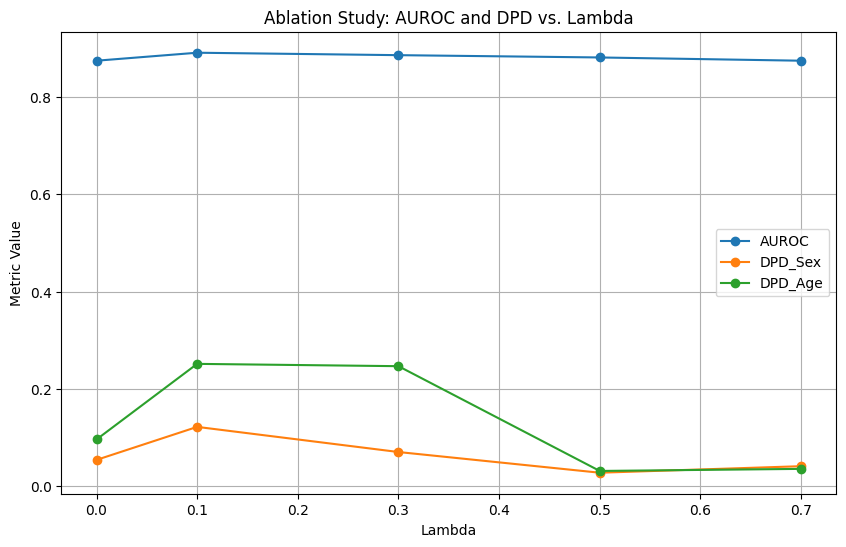

In [ ]:
lambda_values = [0.0, 0.1, 0.3, 0.5, 0.7]
ablation_results = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Define device here

for lambda_val in lambda_values:
    encoder = Encoder().to(device) # Use device
    classifier = Classifier().to(device) # Use device
    adv_sex = Adversary(num_classes=2).to(device) # Use device, specify num_classes
    adv_age = Adversary(num_classes=3).to(device) # Use device, specify num_classes

    # Assuming train_model is defined and takes device as argument
    encoder, classifier = train_model(encoder, classifier, adv_sex, adv_age, train_loader, device, lambda_val)
    # Assuming evaluate_model is defined and takes device as argument
    auroc, acc, f1, dpd_sex, dpd_age = evaluate_model(encoder, classifier, test_loader, device)
    ablation_results.append({'Lambda': lambda_val, 'AUROC': auroc, 'DPD_Sex': dpd_sex, 'DPD_Age': dpd_age}) # Include DPD_Age
    print(f"Lambda={lambda_val}: AUROC={auroc:.4f}, DPD_Sex={dpd_sex:.4f}, DPD_Age={dpd_age:.4f}") # Print DPD_Age


# Plot ablation
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6)) # Increase figure size for better readability
plt.plot([r['Lambda'] for r in ablation_results], [r['AUROC'] for r in ablation_results], label='AUROC', marker='o') # Add markers
plt.plot([r['Lambda'] for r in ablation_results], [r['DPD_Sex'] for r in ablation_results], label='DPD_Sex', marker='o') # Add markers
plt.plot([r['Lambda'] for r in ablation_results], [r['DPD_Age'] for r in ablation_results], label='DPD_Age', marker='o') # Plot DPD_Age
plt.xlabel('Lambda')
plt.ylabel('Metric Value') # Add ylabel
plt.title('Ablation Study: AUROC and DPD vs. Lambda') # Add title
plt.legend()
plt.grid(True) # Add grid
plt.savefig('ablation_lambda.png')
plt.show() # Show plot

Subsampled dataset size: 4360 records
Label distribution: label
0    3785
1     575
Name: count, dtype: int64
Sex distribution: sex
0    2263
1    2097
Name: count, dtype: int64
Age group distribution: age_group
2    2404
1    1371
0     585
Name: count, dtype: int64
Training baseline model for plotting...
Training adversarial model for plotting...


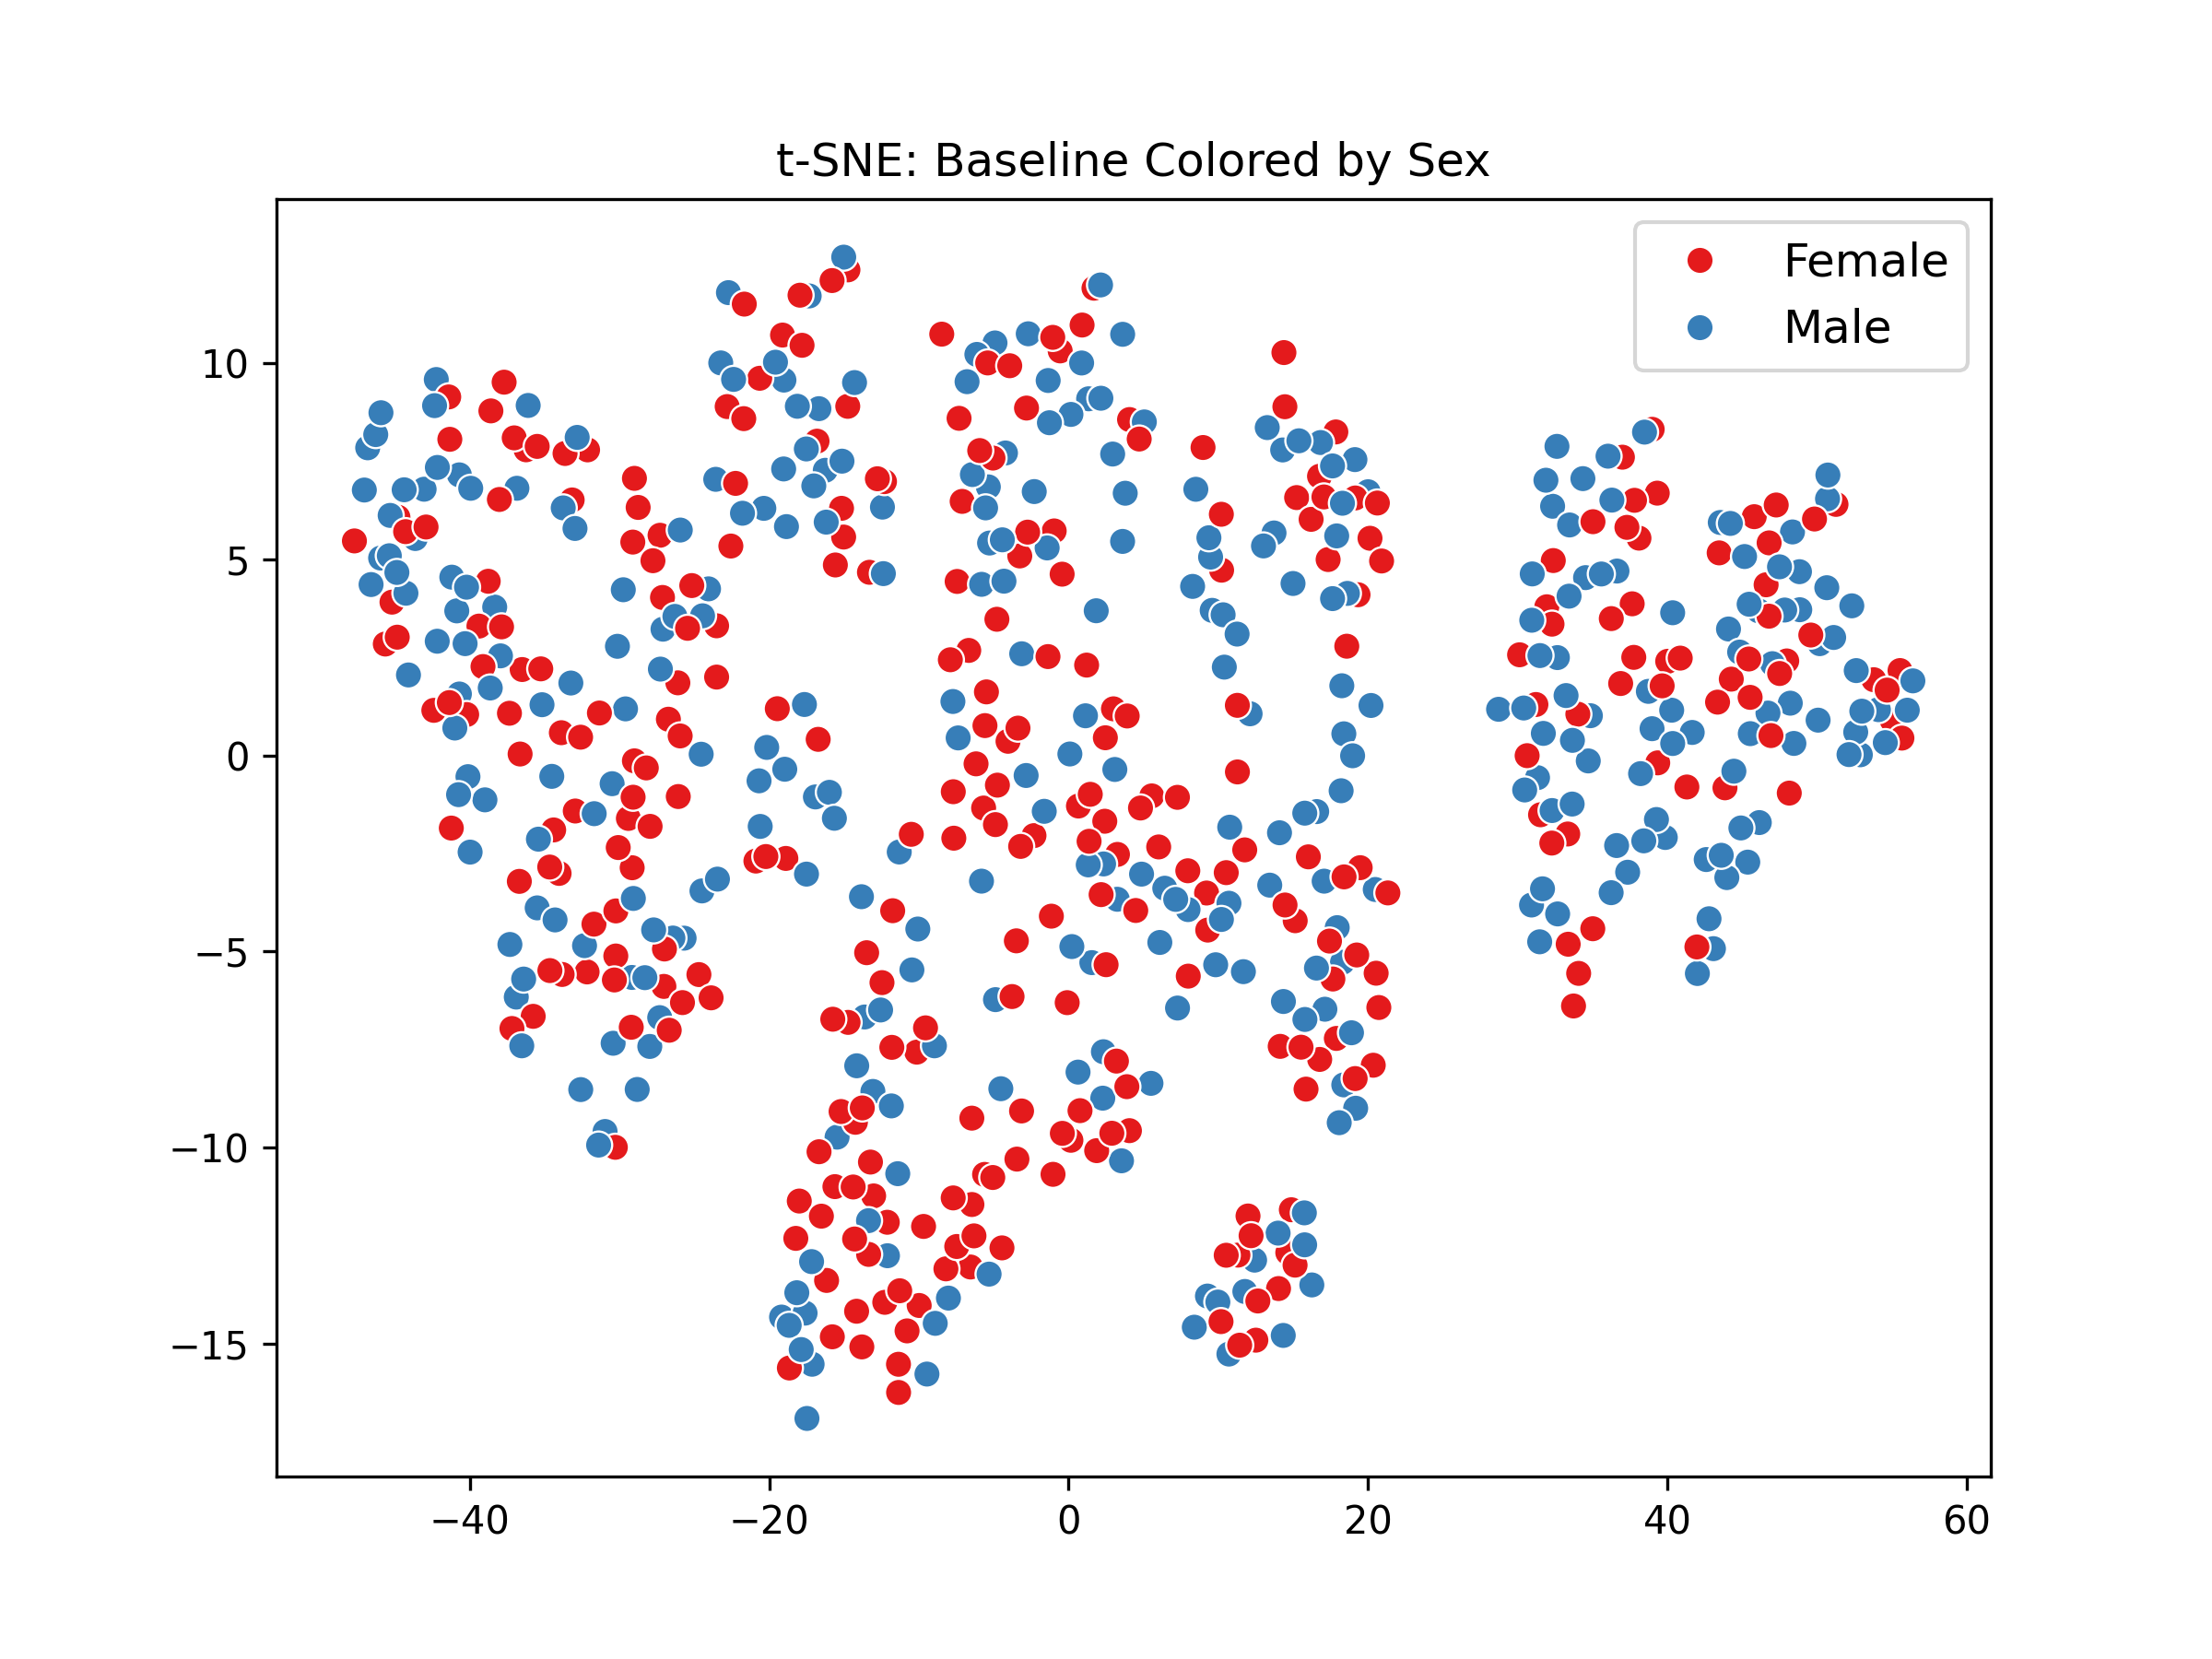

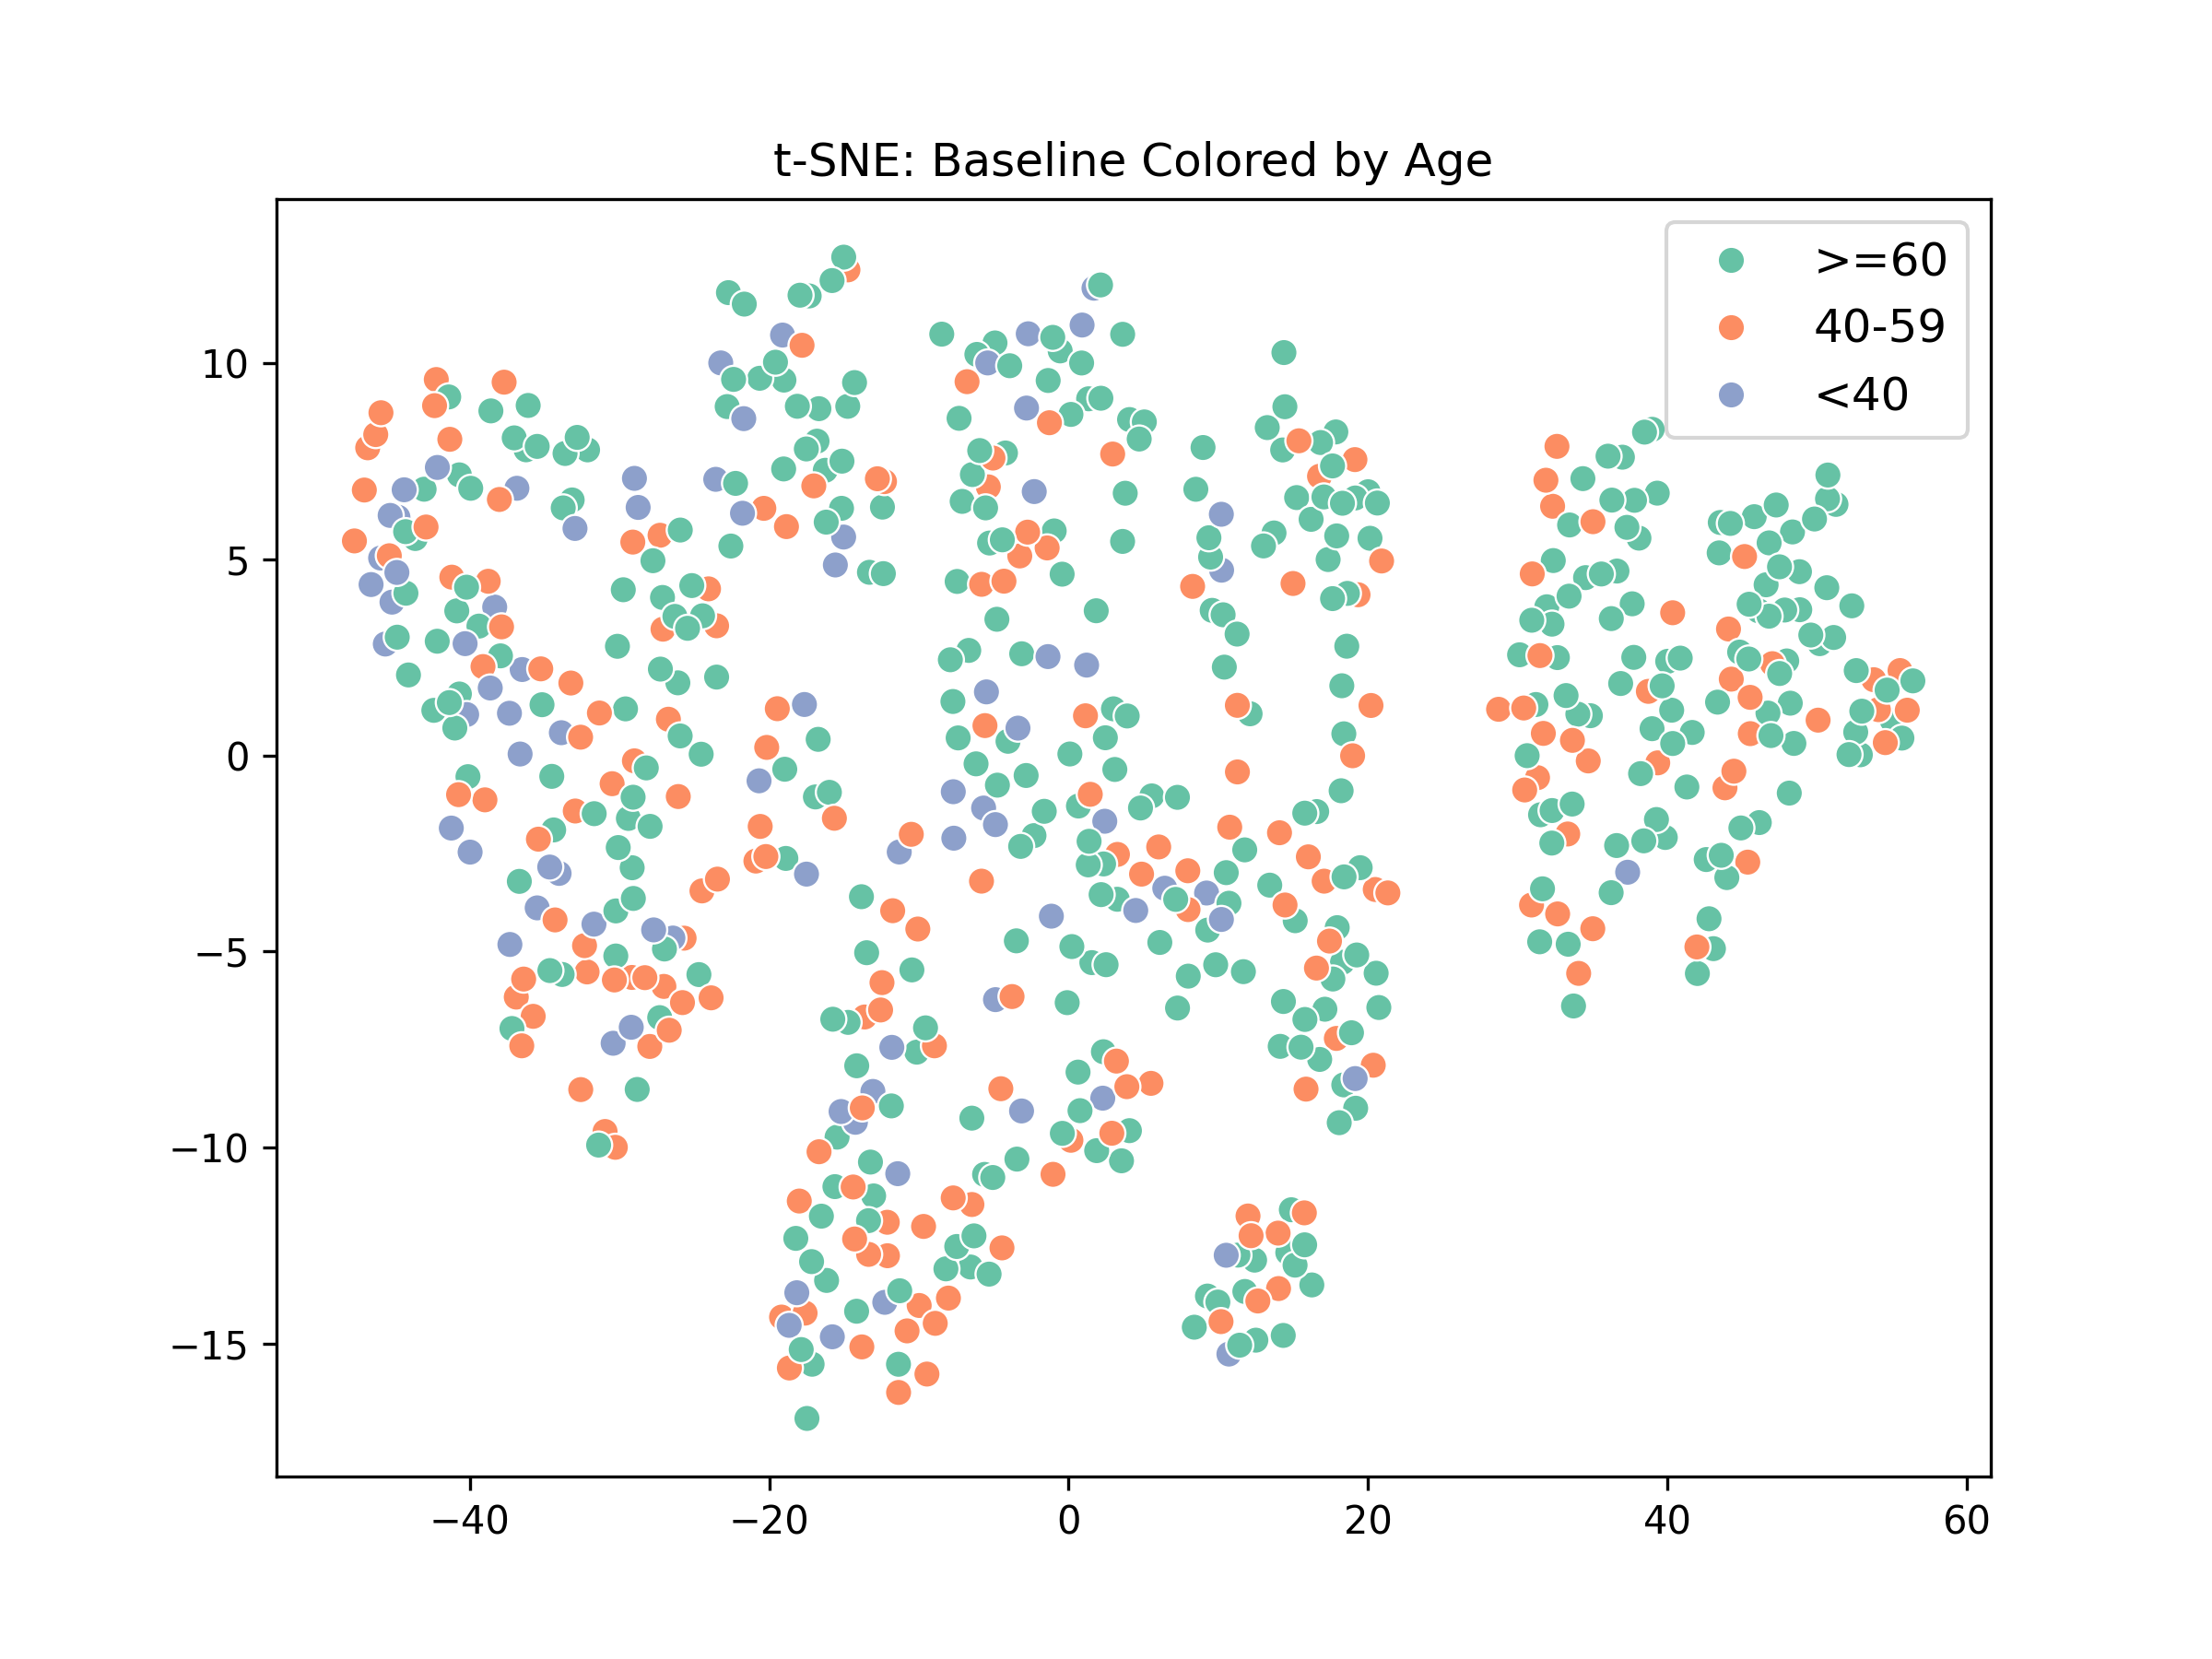

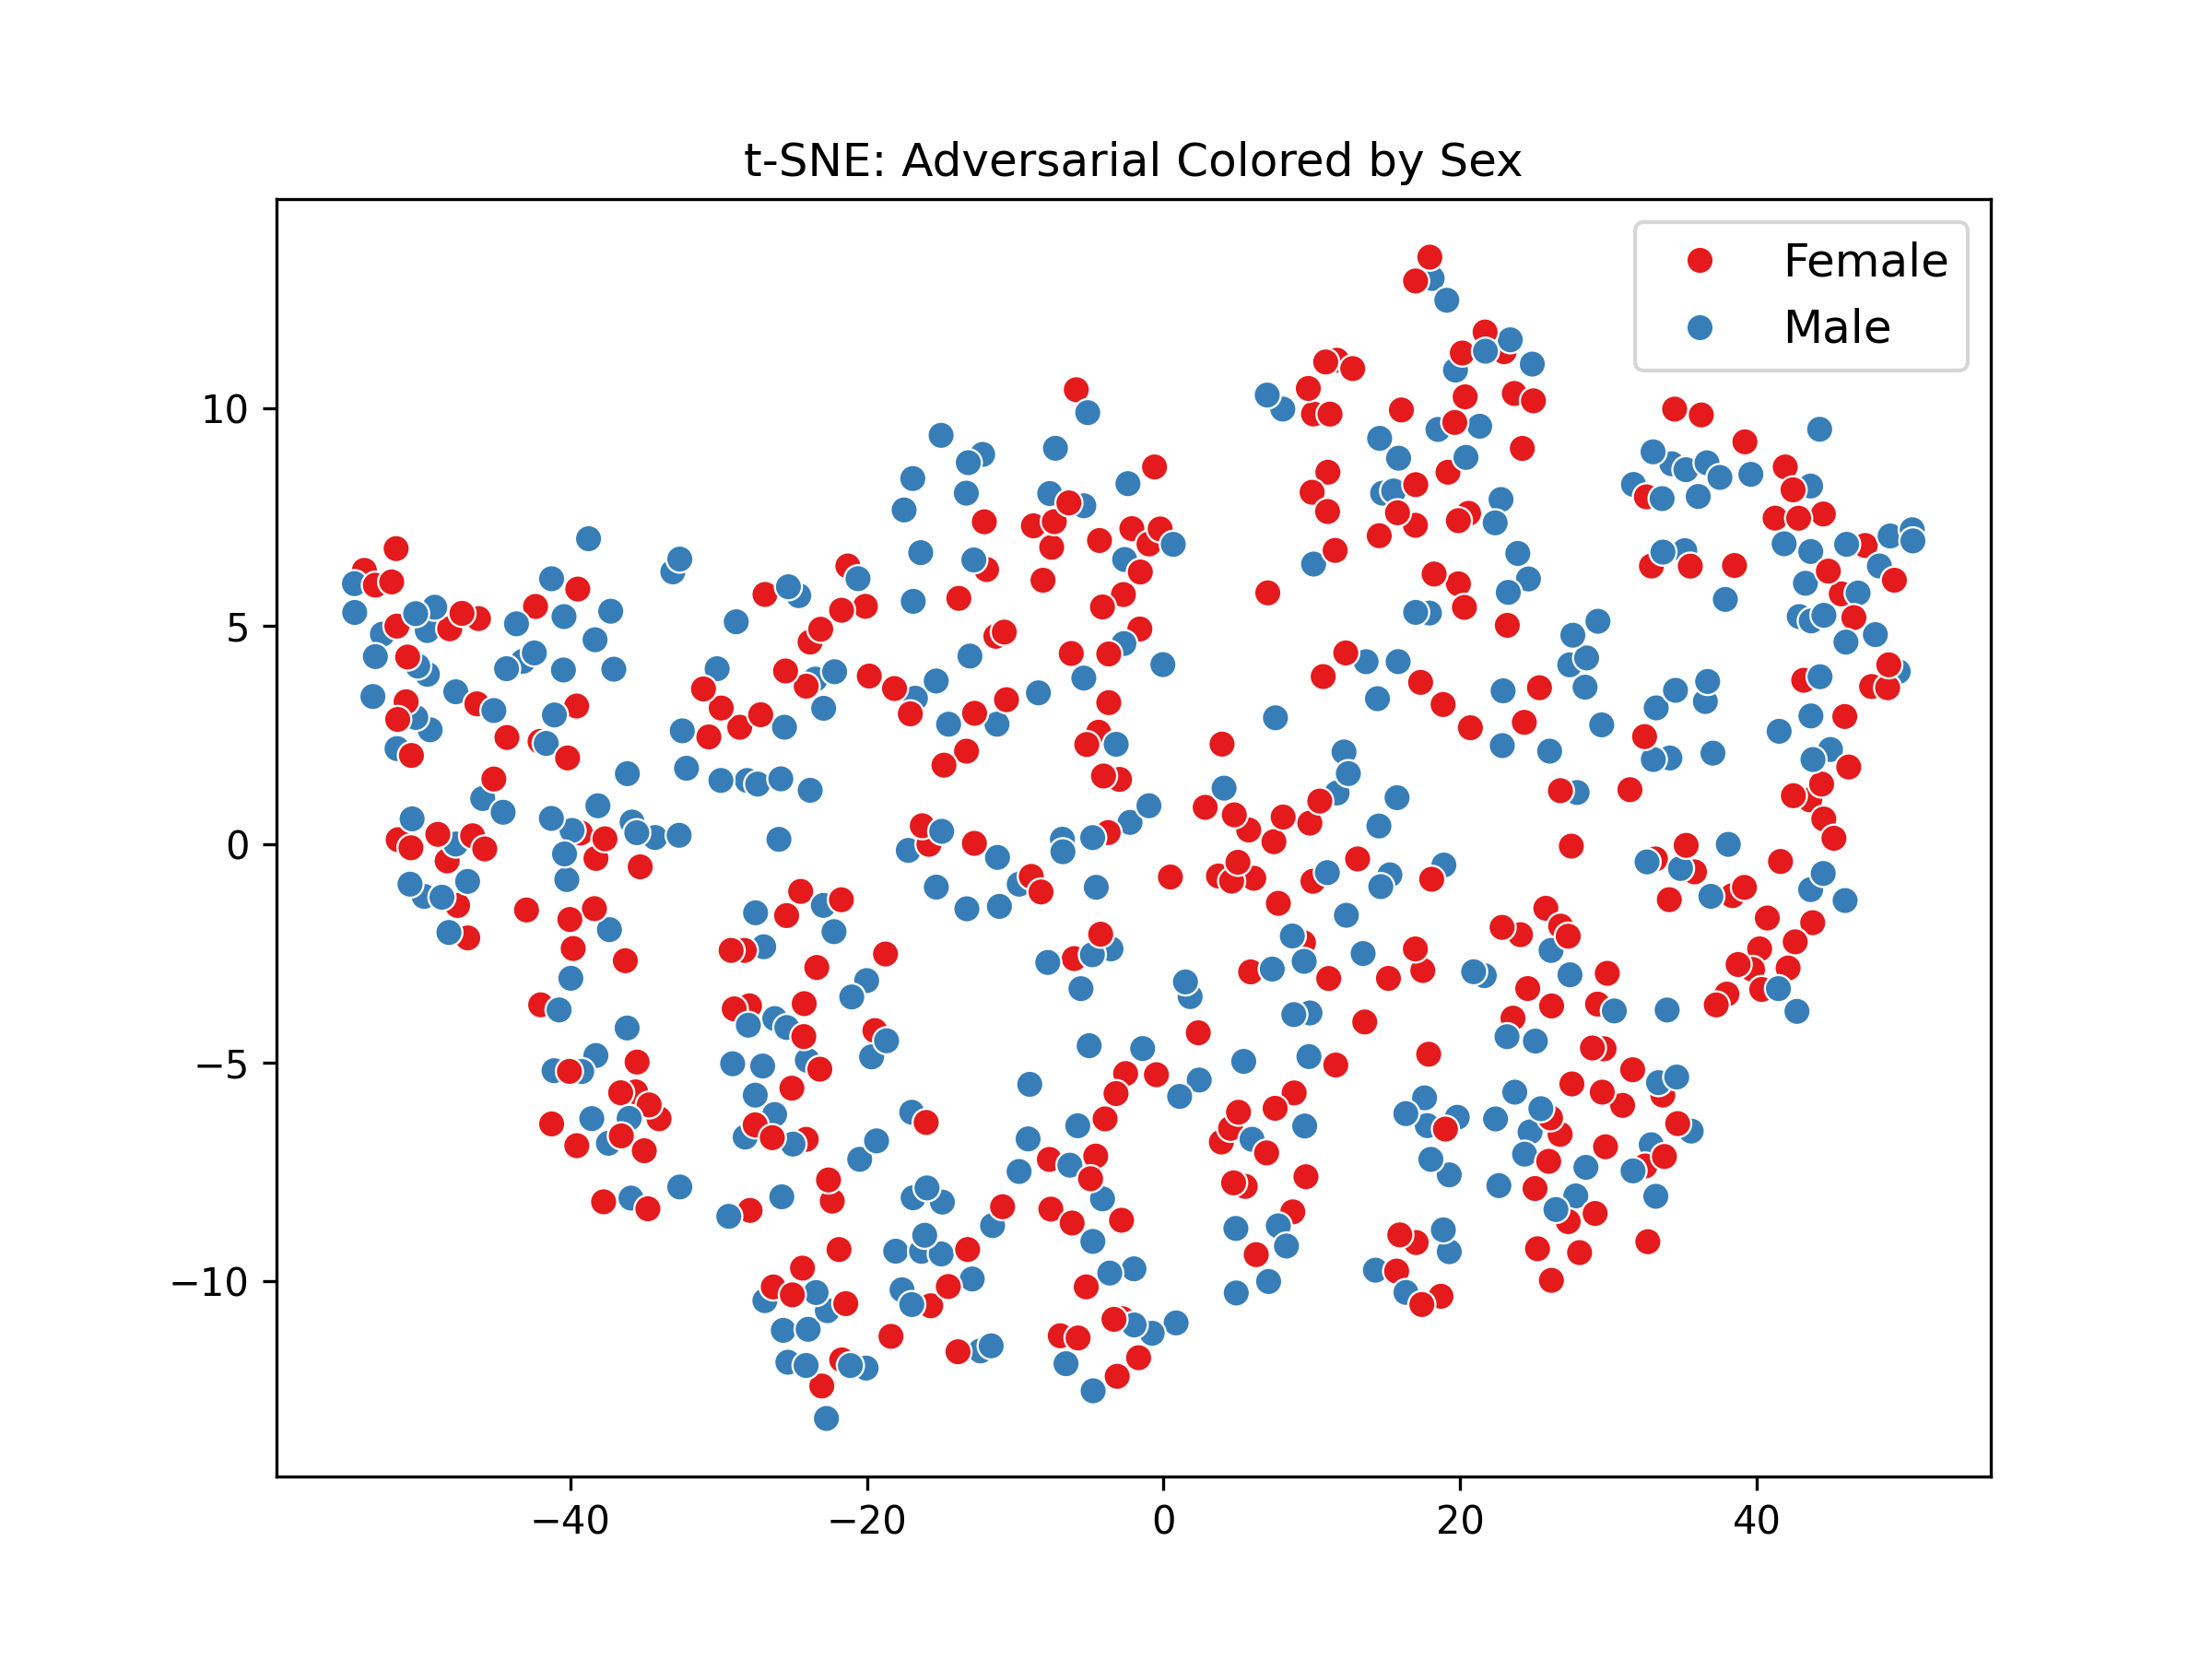

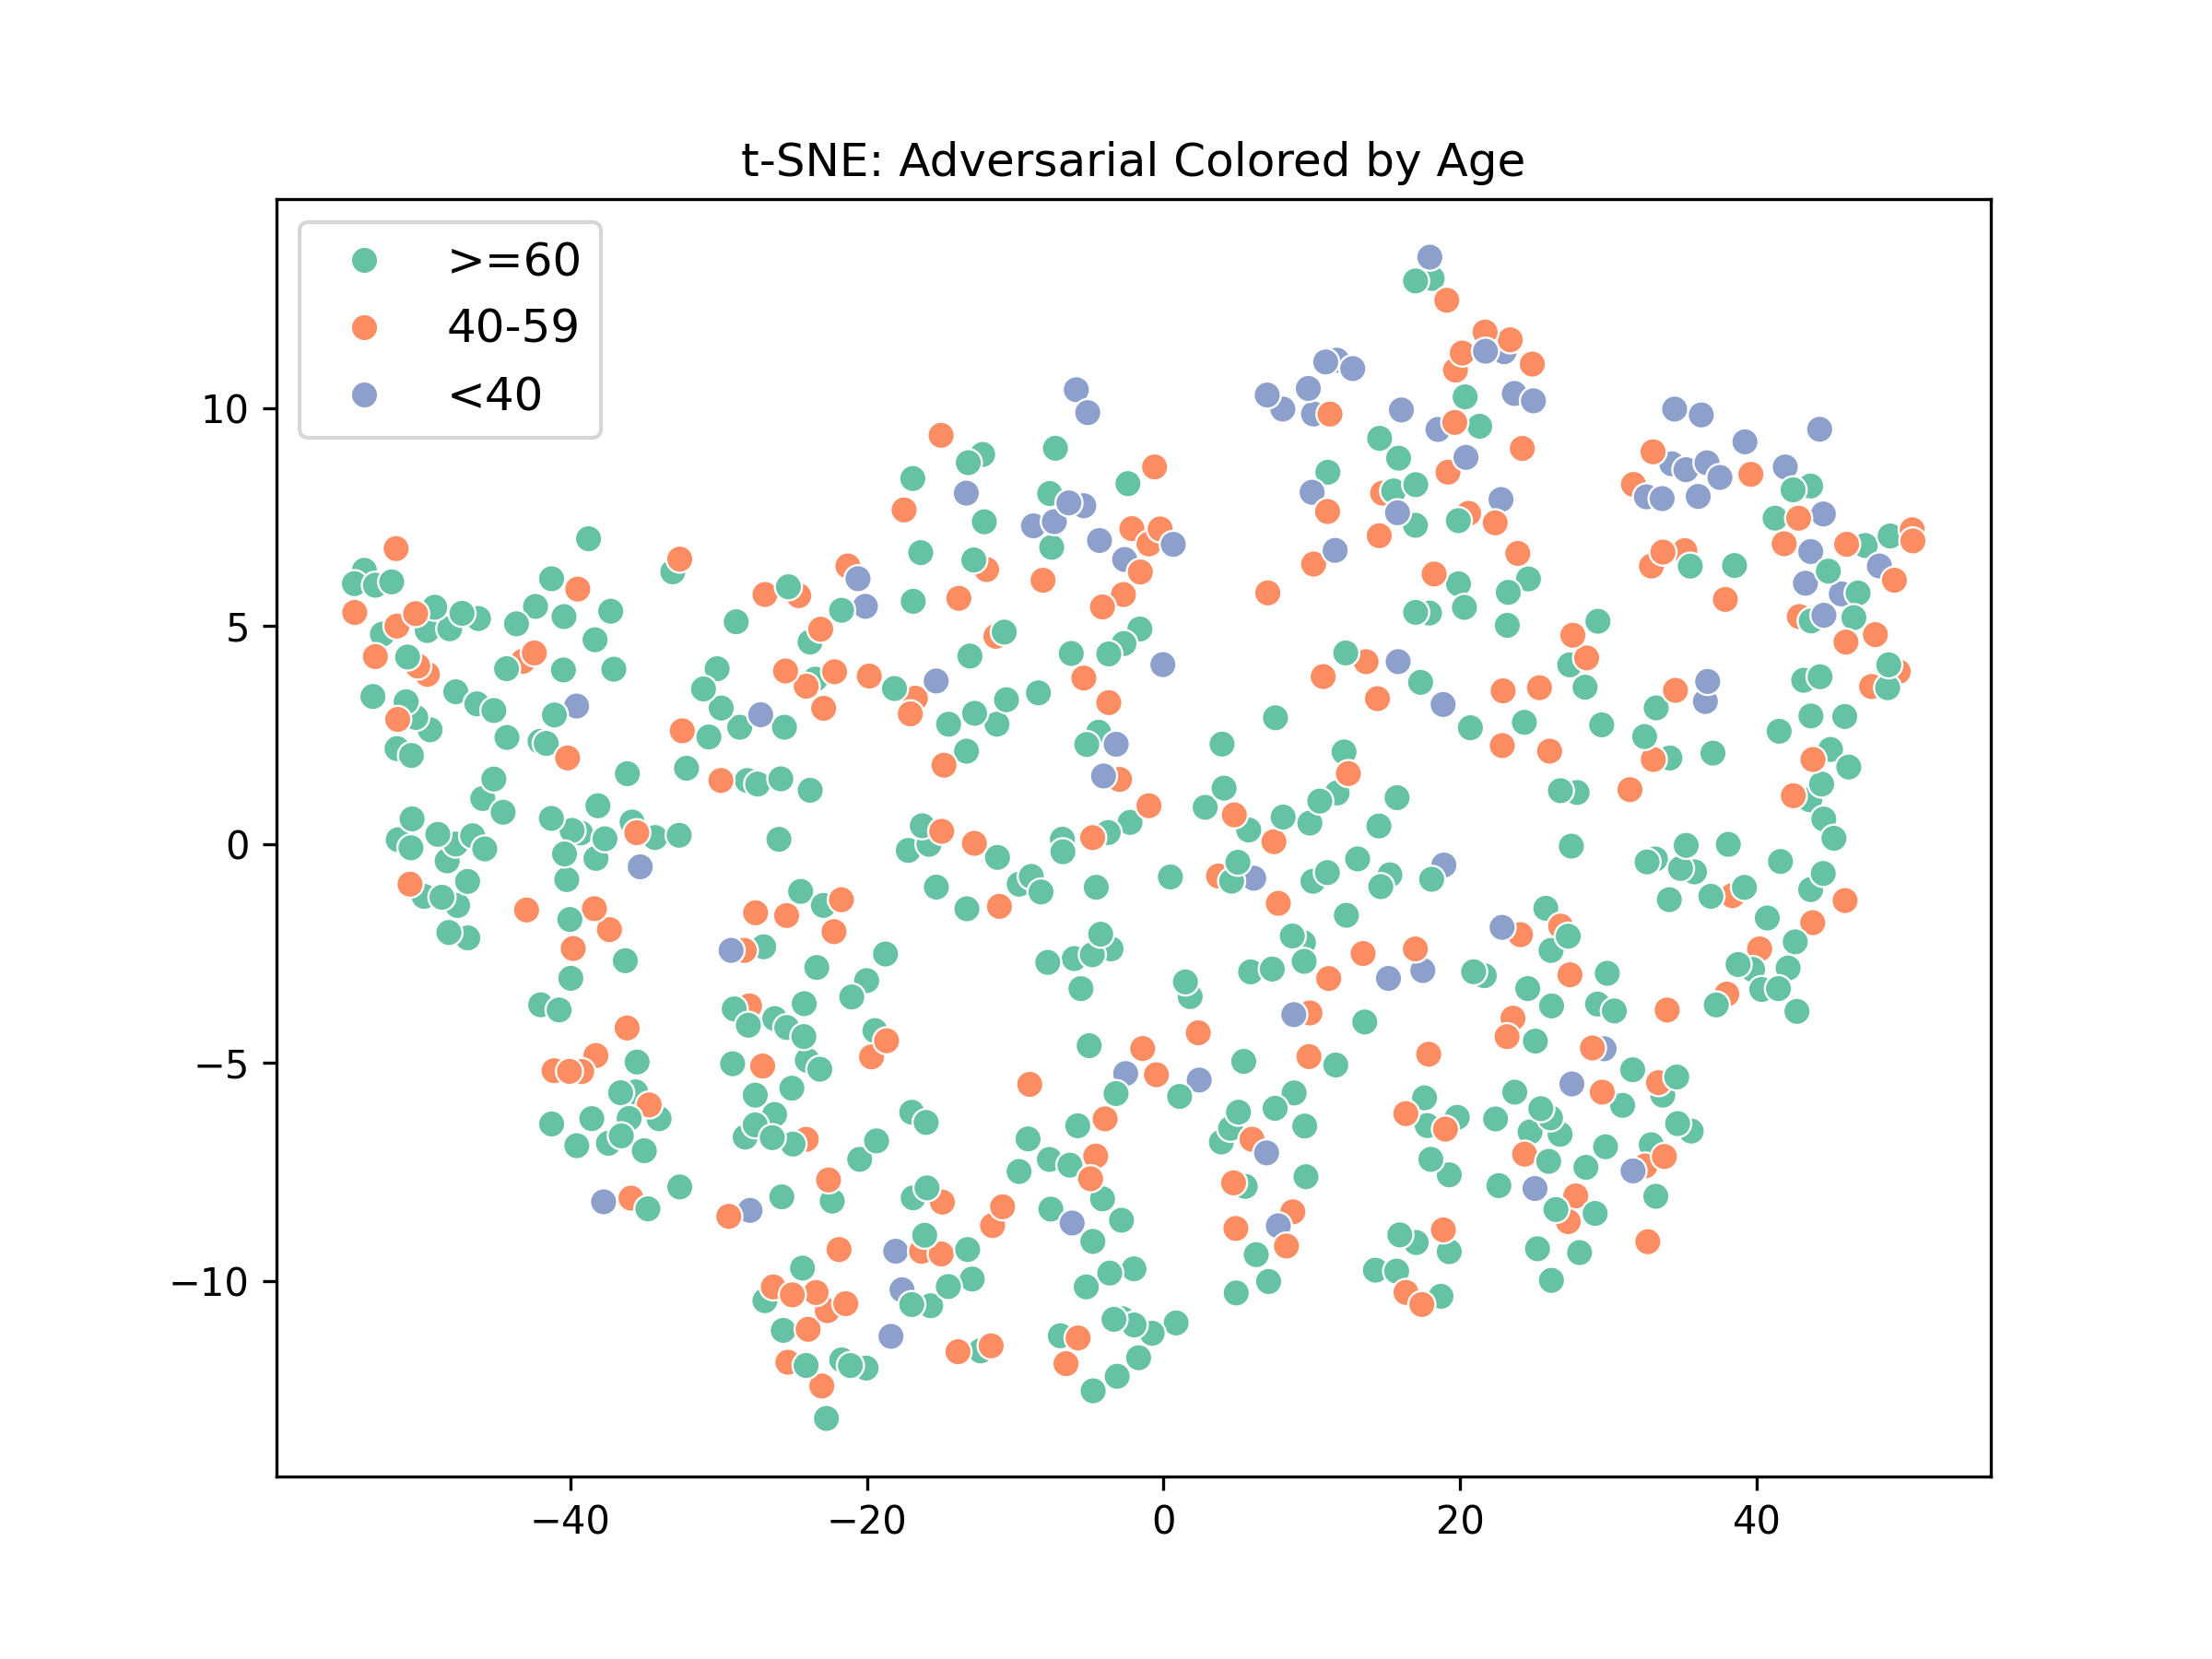

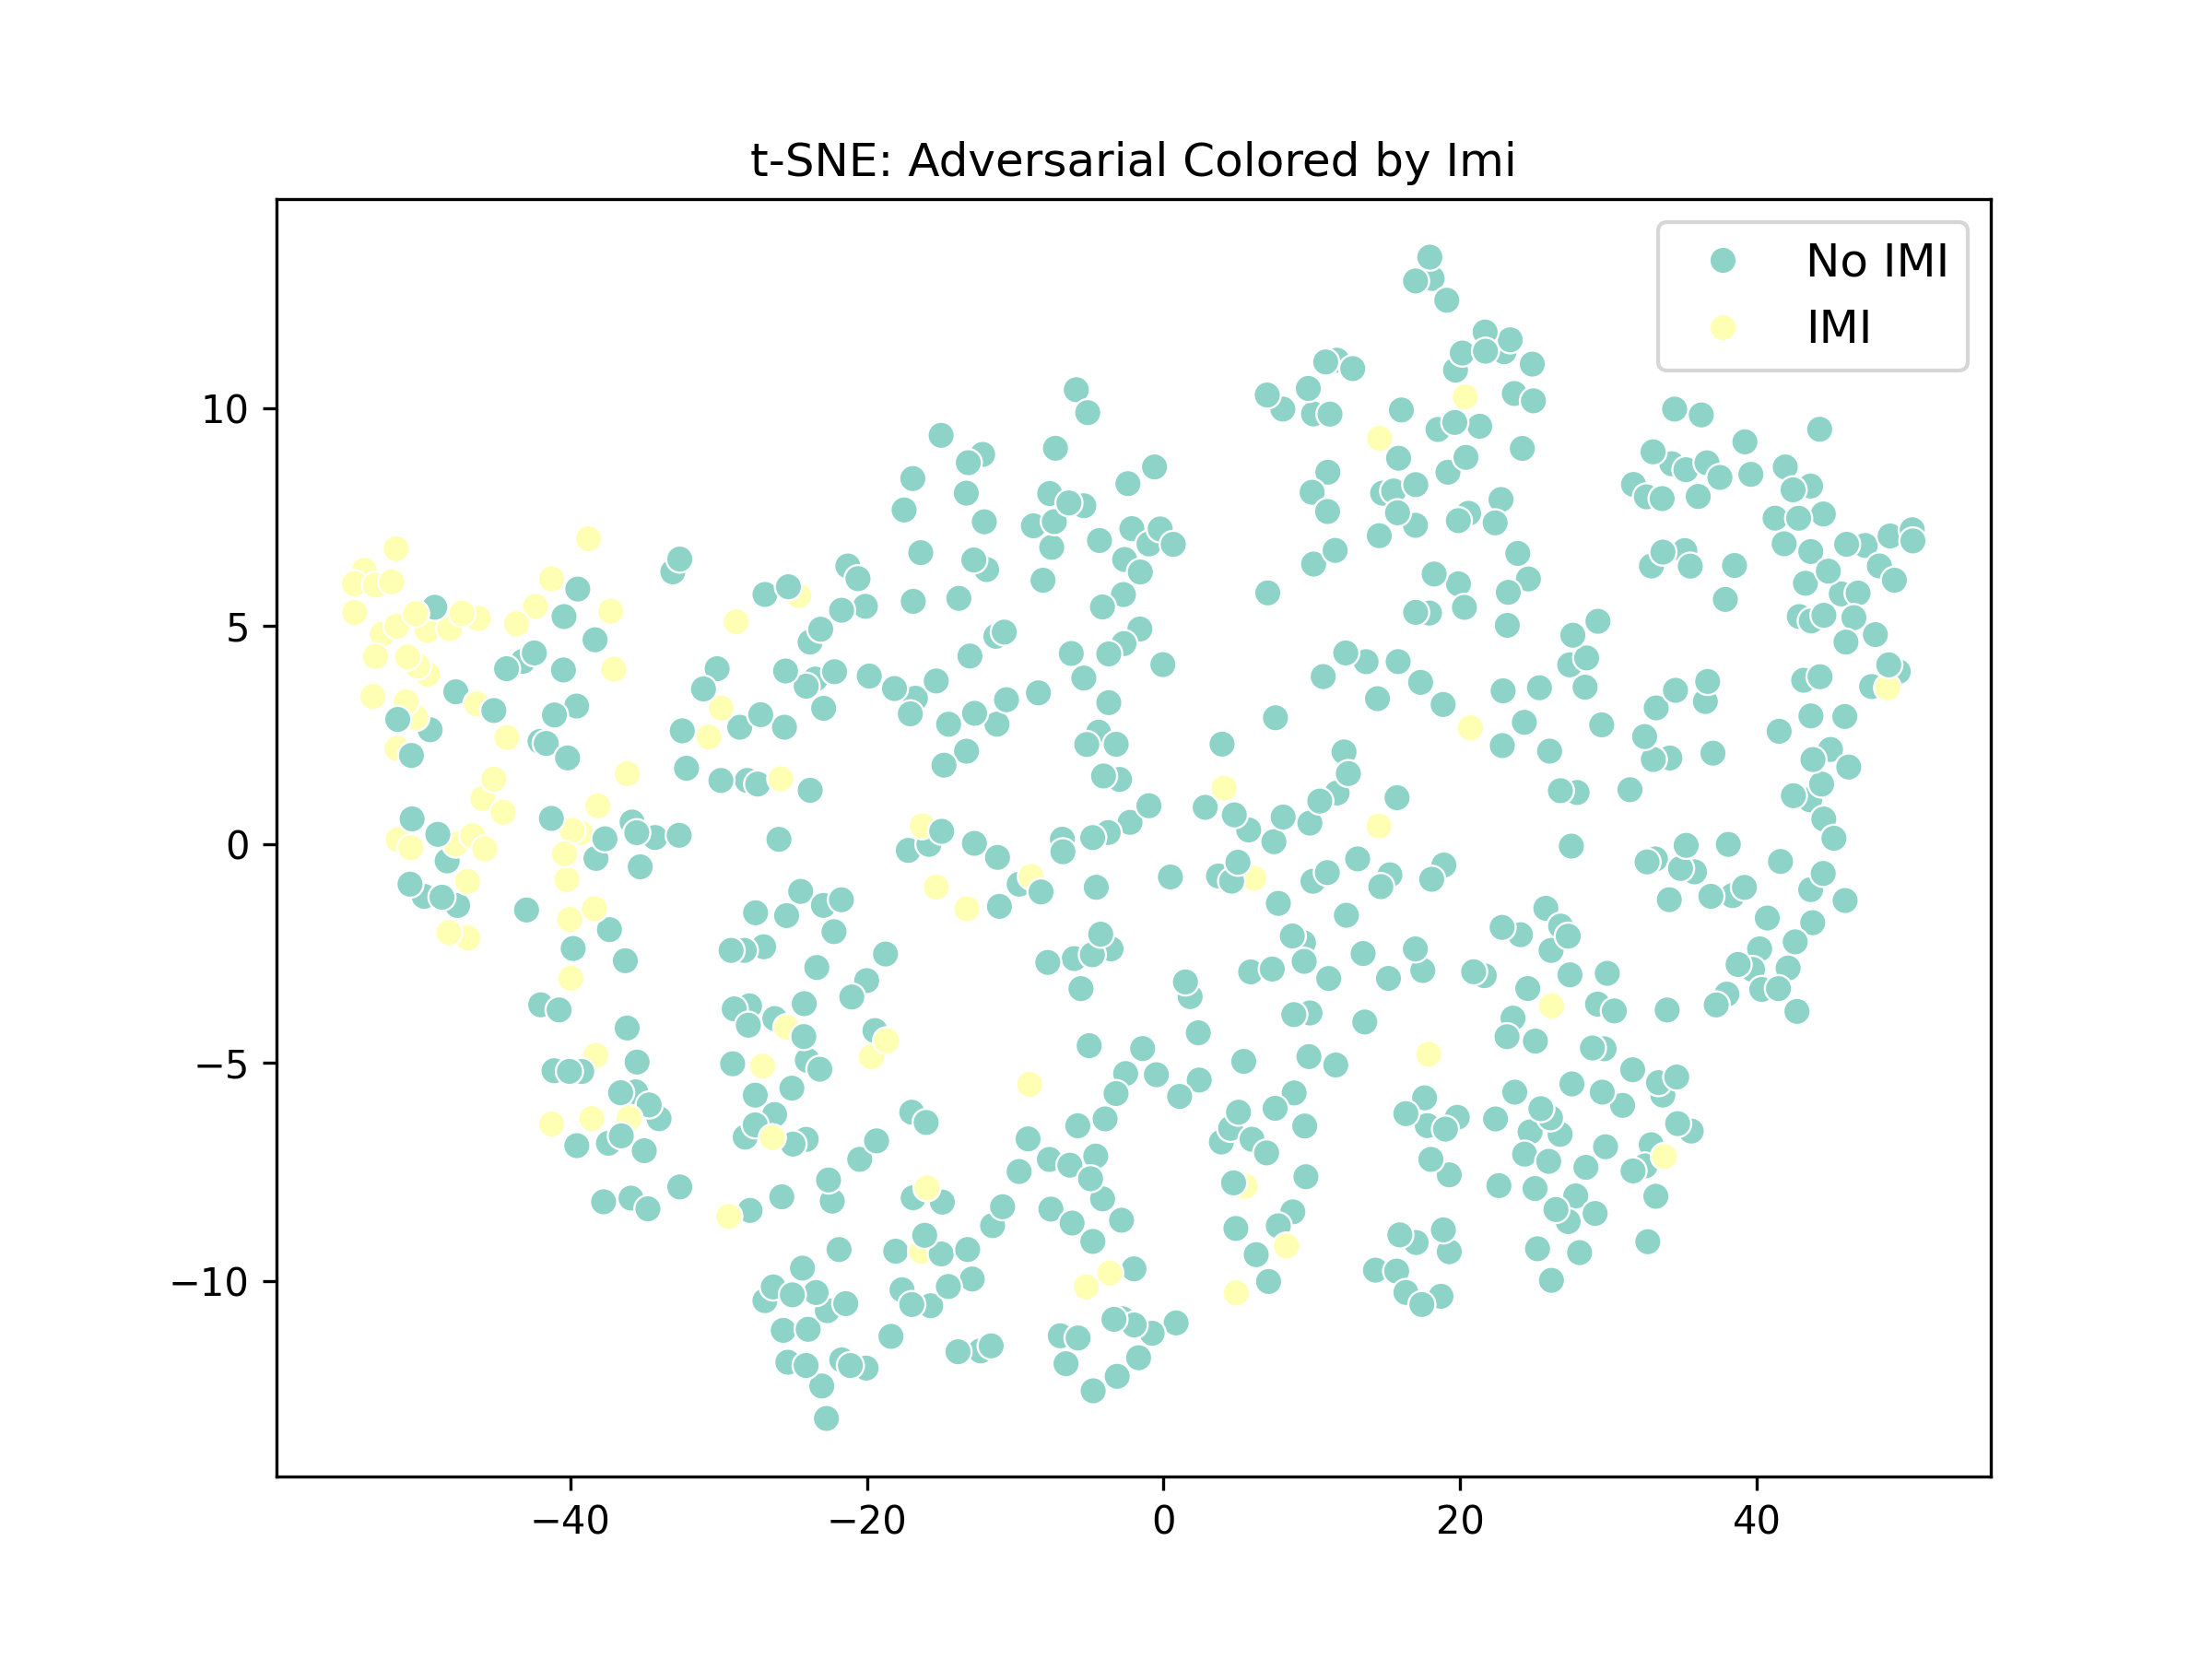

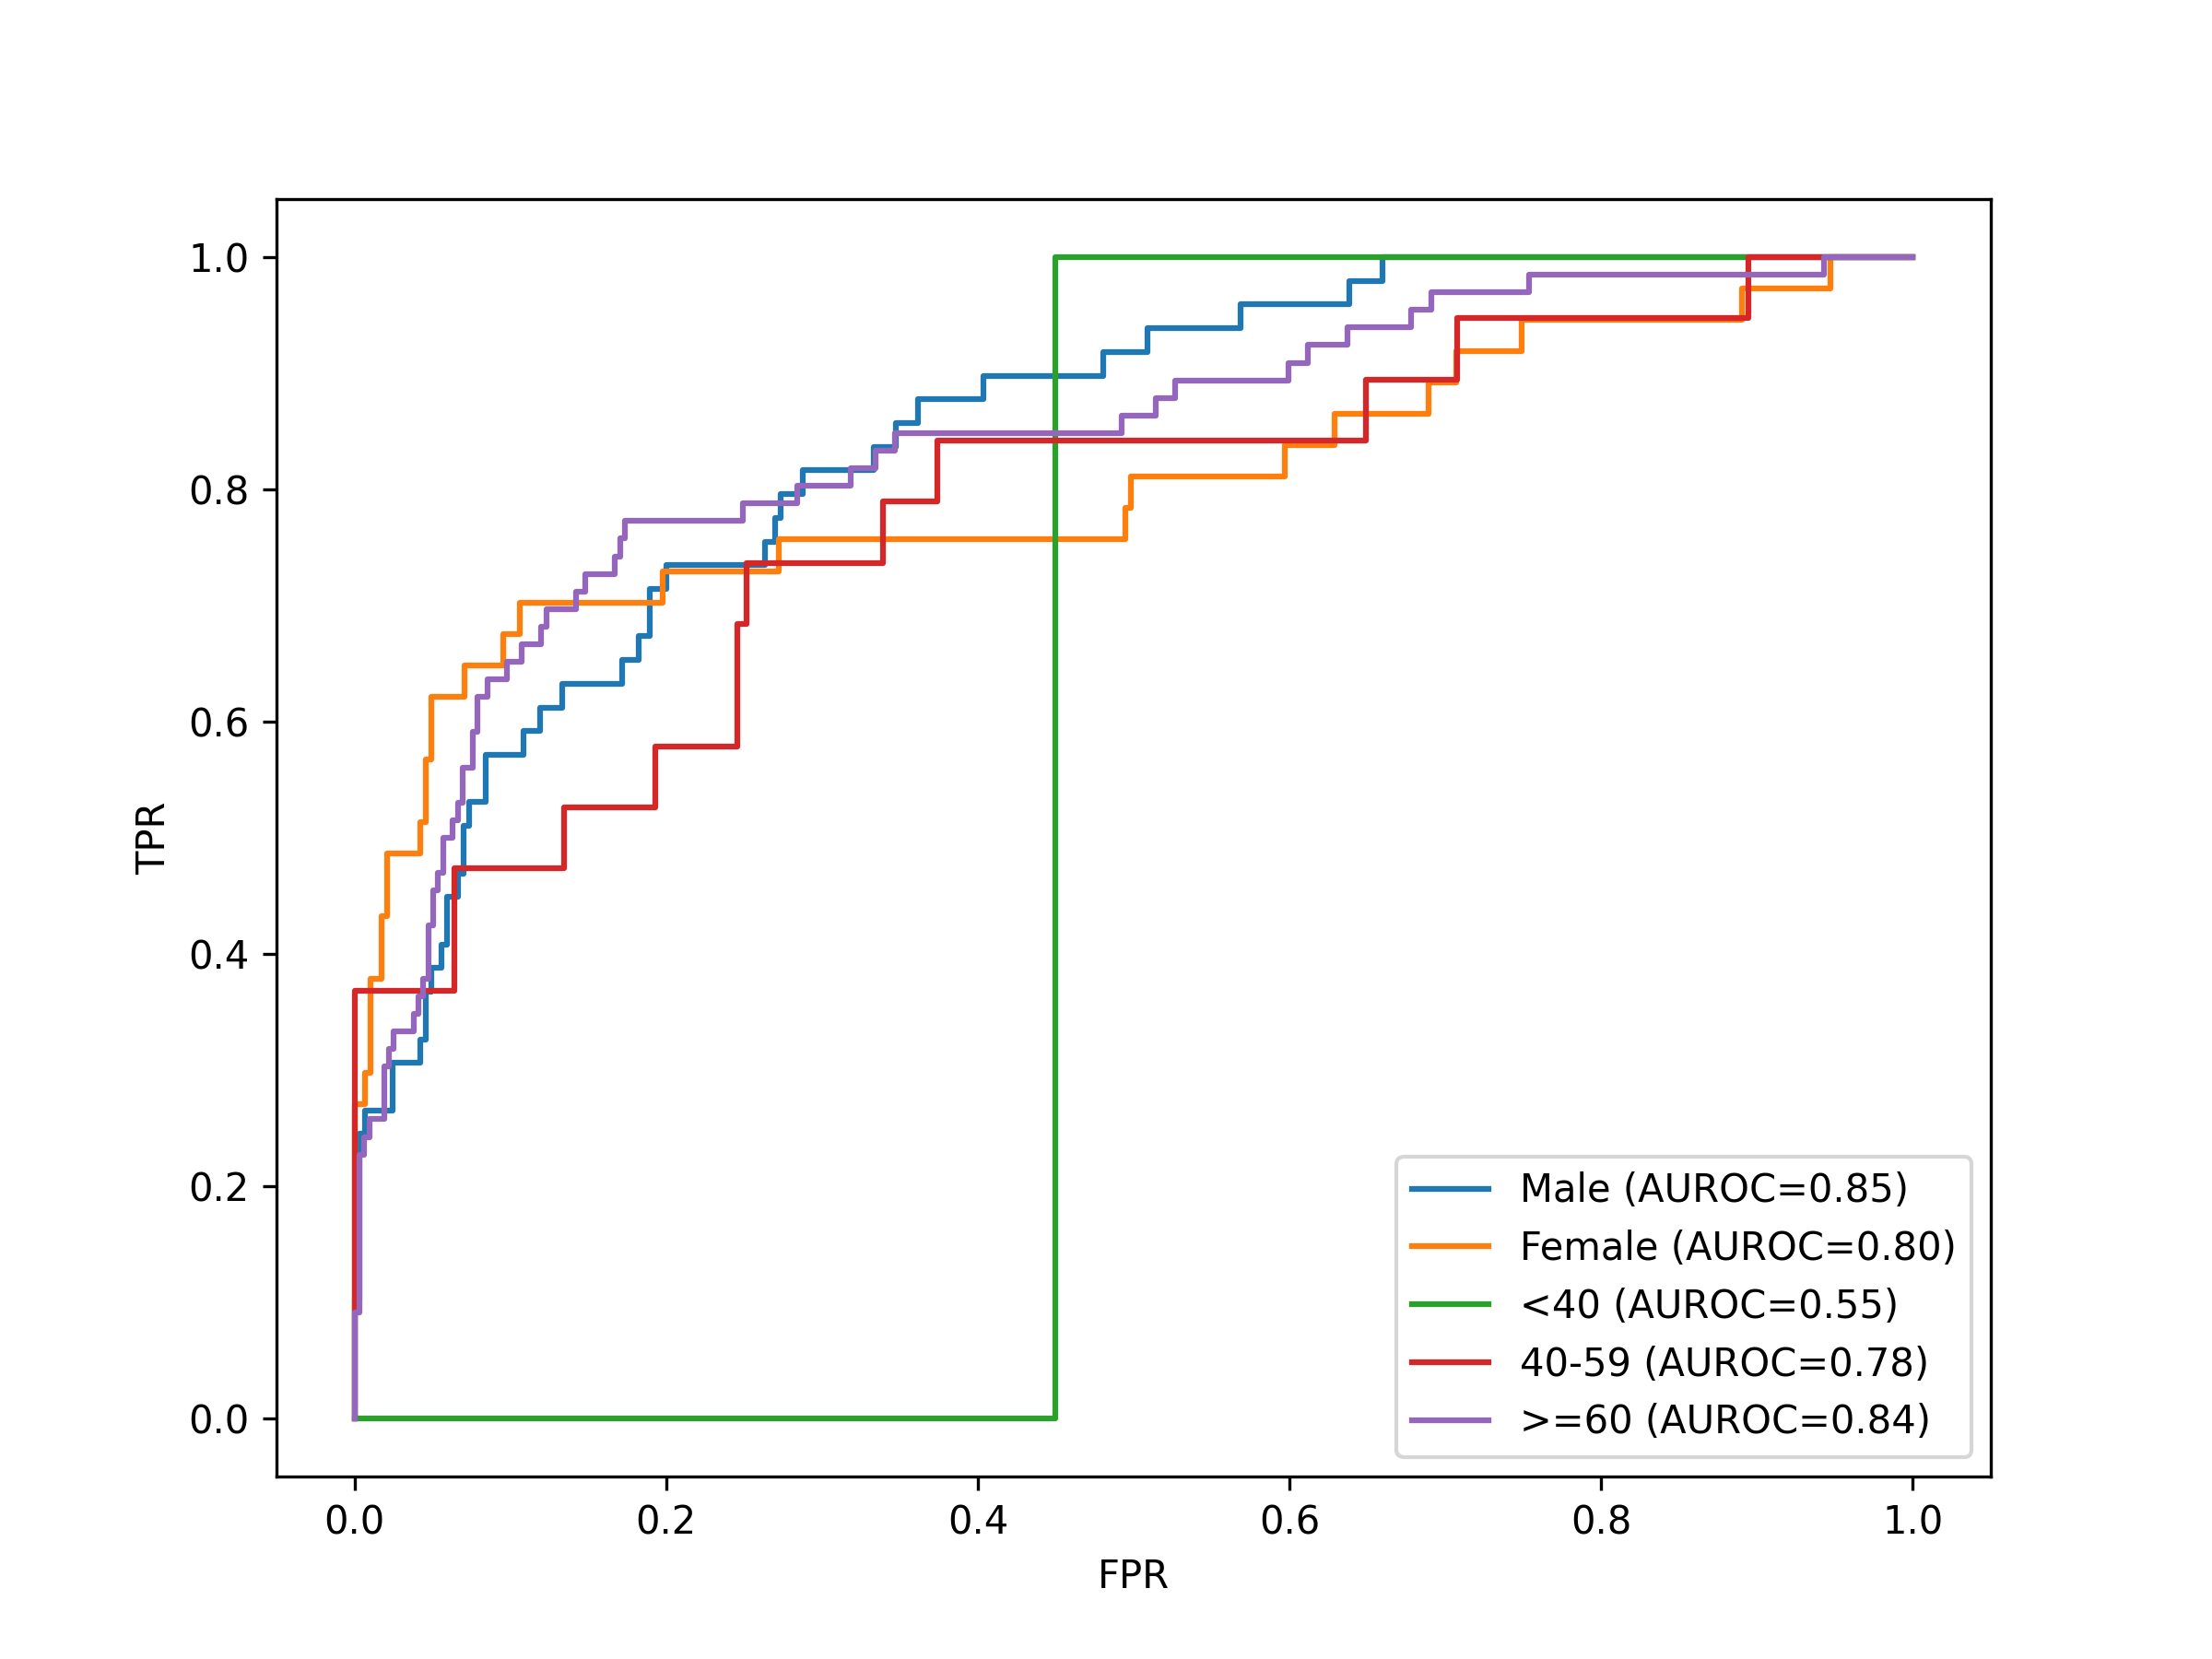

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, roc_auc_score
from IPython import display # Import display
import pandas as pd # Import pandas for data loading
import wfdb # Import wfdb for data loading
import os # Import os for path joining
import ast # Import ast for literal_eval
from sklearn.model_selection import train_test_split # Import train_test_split
from torch.utils.data import Dataset, DataLoader # Import Dataset and DataLoader

# Define data path - Copied from previous cell
DATA_PATH = '/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# Custom Dataset class - Copied from previous cell
class ECGDataset(Dataset):
    def __init__(self, signals, labels, sexes, ages):
        self.signals = torch.tensor(signals, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)  # Labels should be long for CrossEntropyLoss
        self.sexes = torch.tensor(sexes, dtype=torch.long)
        self.ages = torch.tensor(ages, dtype=torch.long)
    def __len__(self): return len(self.signals)
    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx], self.sexes[idx], self.ages[idx]

# Data loading function - Copied from previous cell
def load_ptbxl_data_robust(data_path, subsample_fraction=0.2):
    metadata_path = os.path.join(data_path, 'ptbxl_database.csv')
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata file not found at {metadata_path}")
    metadata = pd.read_csv(metadata_path)

    # Subsample the dataset
    metadata = metadata.sample(frac=subsample_fraction, random_state=42)
    print(f"Subsampled dataset size: {len(metadata)} records")

    # Filter for MI detection (binary classification)
    mi_codes = ['IMI', 'AMI']
    # Parse scp_codes (stored as string representation of dict)
    metadata['scp_codes'] = metadata['scp_codes'].apply(ast.literal_eval)
    metadata['label'] = metadata['scp_codes'].apply(lambda x: 1 if any(code in x for code in mi_codes) else 0)
    if metadata['label'].isnull().any():
        raise ValueError("Found NaN values in labels")
    print("Label distribution:", metadata['label'].value_counts())

    # Handle sex: Ensure no NaN values, map to 0/1
    if metadata['sex'].isnull().any():
        print("Found NaN values in 'sex'. Filling with mode.")
        metadata['sex'] = metadata['sex'].fillna(metadata['sex'].mode()[0])
    metadata['sex'] = metadata['sex'].map({0: 0, 1: 1})
    if metadata['sex'].isnull().any():
        raise ValueError("Failed to map 'sex'. Contains invalid values.")
    print("Sex distribution:", metadata['sex'].value_counts())

    # Handle age: Ensure numeric, handle invalid values
    metadata['age'] = pd.to_numeric(metadata['age'], errors='coerce')

    # Handle invalid ages
    if metadata['age'].isnull().any():
        print("Found NaN values in 'age'. Filling with median.")
        median_age = metadata['age'].median()
        metadata['age'] = metadata['age'].fillna(median_age)

    # Clip ages to a reasonable range
    metadata['age'] = metadata['age'].clip(lower=0, upper=120)

    # Bin age into groups
    metadata['age_group'] = pd.cut(metadata['age'],
                                   bins=[0, 40, 60, 121],
                                   labels=[0, 1, 2],
                                   right=False,
                                   include_lowest=True)

    if metadata['age_group'].isnull().any():
        invalid_rows = metadata[metadata['age_group'].isnull()]
        print("Rows with invalid age_group:", invalid_rows[['age', 'age_group']])
        raise ValueError("Failed to bin 'age'. Contains invalid values after cleaning.")
    print("Age group distribution:", metadata['age_group'].value_counts())

    # Load ECG signals
    signals = []
    labels = []
    sexes = []
    ages = []

    for idx, row in metadata.iterrows():
        record_path = os.path.join(data_path, row['filename_lr'])
        try:
            signal, _ = wfdb.rdsamp(record_path)
            signal = (signal - signal.mean(axis=0)) / (signal.std(axis=0) + 1e-8) # Fixed error here
            signal = signal[:1000, :]  # Truncate to 1000 samples
            signals.append(signal)
            labels.append(row['label'])
            sexes.append(row['sex'])
            ages.append(row['age_group'])
        except Exception as e:
            print(f"Error loading {record_path}: {e}")
            continue

    signals = np.array(signals)
    labels = np.array(labels)
    sexes = np.array(sexes)
    ages = np.array(ages)

    # Final validation
    if np.any(np.isnan(labels)):
        raise ValueError("NaN values found in labels after processing")
    if np.any(np.isnan(sexes)):
        raise ValueError("NaN values found in sexes after processing")
    if np.any(np.isnan(ages)):
         raise ValueError("NaN values found in ages after processing")

    return signals, labels, sexes, ages

# Define model (as in original) - Copied from previous cell
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class Encoder(nn.Module):
    def __init__(self, input_channels=12, output_dim=128):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class Classifier(nn.Module):
    def __init__(self, input_dim=128, num_classes=2):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

class Adversary(nn.Module):
    def __init__(self, input_dim=128, num_classes=2):
        super(Adversary, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, lambda_):
        x = GradientReversalLayer.apply(x, lambda_)
        return self.model(x)

# Training function - Copied from previous cell
def train_model(encoder, classifier, adv_sex, adv_age, train_loader, device, lambda_val=0.3, epochs=20):
    optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()) +
                          list(adv_sex.parameters()) + list(adv_age.parameters()), lr=0.001)
    criterion_class = nn.CrossEntropyLoss() # Changed to CrossEntropyLoss
    criterion_adv_sex = nn.CrossEntropyLoss() # Assuming 2 classes for sex adversary
    criterion_adv_age = nn.CrossEntropyLoss() # Assuming 3 classes for age adversary


    for epoch in range(epochs):
        encoder.train()
        classifier.train()
        adv_sex.train()
        adv_age.train()
        for signals, labels, sexes, ages in train_loader:
            signals = signals.permute(0, 2, 1).to(device)
            labels, sexes, ages = labels.to(device), sexes.to(device), ages.to(device)
            optimizer.zero_grad()

            # Train classifier and encoder to minimize main task loss and maximize adversary loss
            z = encoder(signals)
            pred = classifier(z) # Removed .squeeze()
            # Ensure labels are float for BCELoss
            loss_class = criterion_class(pred, labels)

            pred_sex = adv_sex(GradientReversalLayer.apply(z, lambda_val), lambda_val)
            pred_age = adv_age(GradientReversalLayer.apply(z, lambda_val), lambda_val)
            loss_adv = criterion_adv_sex(pred_sex, sexes) + criterion_adv_age(pred_age, ages)
            loss = loss_class - lambda_val * loss_adv

            loss.backward()
            optimizer.step()

            # Train adversaries to minimize adversary loss
            optimizer.zero_grad()
            z = encoder(signals.detach())  # Detach to prevent gradients flowing to encoder
            pred_sex = adv_sex(z, lambda_val) # Added lambda_val
            pred_age = adv_age(z, lambda_val) # Added lambda_val
            loss_adv = criterion_adv_sex(pred_sex, sexes) + criterion_adv_age(pred_age, ages)

            loss_adv.backward()
            optimizer.step()


    return encoder, classifier


def plot_tsne(encoder, loader, name, device, color_by='sex'):
    encoder.eval()
    z_all, labels_all, sexes_all, ages_all = [], [], [], []
    with torch.no_grad():
        for signals, labels, sexes, ages in loader:
            signals = signals.permute(0, 2, 1).to(device)
            z = encoder(signals).cpu().numpy()
            z_all.extend(z); labels_all.extend(labels.numpy()); sexes_all.extend(sexes.numpy()); ages_all.extend(ages.numpy())
    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(np.array(z_all))

    plt.figure(figsize=(8, 6))
    if color_by == 'sex':
        sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=['Male' if s == 0 else 'Female' if s == 1 else 'Unknown' for s in sexes_all], palette='Set1', s=50)
    elif color_by == 'age':
        sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=['<40' if a == 0 else '40-59' if a == 1 else '>=60' if a == 2 else 'Unknown' for a in ages_all], palette='Set2', s=50)
    elif color_by == 'imi':
        sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=['IMI' if l == 1 else 'No IMI' for l in labels_all], palette='Set3', s=50)
    plt.title(f't-SNE: {name} Colored by {color_by.capitalize()}')
    plt.legend(fontsize=12)
    plt.savefig(f'tsne_{name}_{color_by}.png', dpi=300)
    plt.close()
    return f'tsne_{name}_{color_by}.png' # Return filename

# AUROC per group
def plot_auroc_per_group(classifier, loader, encoder, device):
    preds, truths = [], []
    sex_attrs, age_attrs = [], [] # Collect sensitive attributes within the function
    with torch.no_grad():
        for signals, labels, sexes, ages in loader:
            signals = signals.permute(0, 2, 1).to(device)
            z = encoder(signals)
            # Apply softmax and take the score for the positive class (index 1)
            pred = torch.softmax(classifier(z), dim=1)[:, 1].cpu().numpy()
            preds.extend(pred); truths.extend(labels.numpy())
            sex_attrs.extend(sexes.numpy()) # Collect sexes
            age_attrs.extend(ages.numpy()) # Collect ages

    # Convert collected attributes to numpy arrays
    sex_attrs = np.array(sex_attrs)
    age_attrs = np.array(age_attrs)
    truths = np.array(truths)
    preds = np.array(preds)

    plt.figure(figsize=(8, 6))
    for group, mask in [('Male', sex_attrs == 0), ('Female', sex_attrs == 1),
                        ('<40', age_attrs == 0), ('40-59', age_attrs == 1), ('>=60', age_attrs == 2)]:
        # Ensure there are samples for the group
        if np.sum(mask) > 0:
            fpr, tpr, _ = roc_curve(truths[mask], preds[mask])
            plt.plot(fpr, tpr, label=f'{group} (AUROC={roc_auc_score(truths[mask], preds[mask]):.2f})')
        else:
            print(f"No samples for group: {group}") # Print a message if no samples
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.savefig('auroc_per_group.png', dpi=300)
    plt.close()
    return 'auroc_per_group.png' # Return filename


# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and split data (subsample to 20%) - Moved from previous cell
signals, labels, sexes, ages = load_ptbxl_data_robust(DATA_PATH, subsample_fraction=0.2)

# Split dataset - Moved from previous cell
X_train, X_temp, y_train, y_temp, sex_train, sex_temp, age_train, age_temp = train_test_split(
    signals, labels, sexes, ages, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test, sex_val, sex_test, age_val, age_test = train_test_split(
    X_temp, y_temp, sex_temp, age_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create DataLoaders - Moved from previous cell
train_dataset = ECGDataset(X_train, y_train, sex_train, age_train)
val_dataset = ECGDataset(X_val, y_val, sex_val, age_val)
test_dataset = ECGDataset(X_test, y_test, sex_test, age_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)


# Train a baseline encoder and classifier for plotting
print("Training baseline model for plotting...")
baseline_encoder = Encoder().to(device)
baseline_classifier = Classifier().to(device)
baseline_optimizer = optim.Adam(list(baseline_encoder.parameters()) + list(baseline_classifier.parameters()), lr=0.001)
baseline_criterion = nn.CrossEntropyLoss()

# Simple training loop for baseline encoder and classifier
for epoch in range(20):
    baseline_encoder.train()
    baseline_classifier.train()
    for signals, labels, sexes, ages in train_loader:
        signals = signals.permute(0, 2, 1).to(device)
        labels = labels.to(device)
        baseline_optimizer.zero_grad()
        z = baseline_encoder(signals)
        pred = baseline_classifier(z)
        loss = baseline_criterion(pred, labels)
        loss.backward()
        baseline_optimizer.step()

# Train the adversarial model for plotting
print("Training adversarial model for plotting...")
encoder = Encoder().to(device)
classifier = Classifier().to(device)
adv_sex = Adversary(num_classes=2).to(device)
adv_age = Adversary(num_classes=3).to(device)
# Using the train_model function defined in a previous cell (Ngfwo7Jz5Gb7)
train_model(encoder, classifier, adv_sex, adv_age, train_loader, device, lambda_val=0.3) # Using lambda=0.3 as an example


# Generate and display t-SNE plots
tsne_plots = []
tsne_plots.append(plot_tsne(baseline_encoder, test_loader, 'Baseline', device, 'sex'))
tsne_plots.append(plot_tsne(baseline_encoder, test_loader, 'Baseline', device, 'age'))
tsne_plots.append(plot_tsne(encoder, test_loader, 'Adversarial', device, 'sex'))
tsne_plots.append(plot_tsne(encoder, test_loader, 'Adversarial', device, 'age'))
tsne_plots.append(plot_tsne(encoder, test_loader, 'Adversarial', device, 'imi'))

for plot_file in tsne_plots:
    display.display(display.Image(plot_file))

# Generate and display AUROC per group plot
auroc_plot_file = plot_auroc_per_group(classifier, test_loader, encoder, device)
display.display(display.Image(auroc_plot_file))